In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
import time
import datetime
import h5py
import glob
import cv2
import scipy.signal
from pathlib import Path

import scipy.signal
# from scipy.sparse.linalg.eigen.arpack import eigs as Eigens
from scipy.sparse.linalg import eigs as Eigens

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
import matplotlib.tri as mtri
from matplotlib import cm

global cbc
cbc = {'red':'#dc143c',
           'blue':'#4269e1',
           'olive':'#bfbf00',
    "bk": "#000000",
    "or": "#E69F00",
    "skb": "#56B4E9",
    "gn": "#009E73",
    "yl": "#F0E442",
    "bl": "#0072B2",
    "vn": "#D55E00",
    "rd": "#CC79A7",
    "gn2": "#4daf4a",
    "pk": "#f781bf",
    "bn": "#a65628",
    "gy": "#999999",
}

In [2]:
def specgr (sig_in,spec_params,thr=0.9, gaussblr_win=(31,3)):
    f, t, Sxx = scipy.signal.spectrogram(sig_in, nperseg=spec_params['nperseg'], noverlap=spec_params['noverlap'],fs=spec_params['fs'], window=spec_params['window'],scaling=spec_params['scaling'], detrend=spec_params['detrend'])
    Sxx = np.log(Sxx + spec_params['eps']) #offset by epsilon to prevent log(0)
    Sxx=(Sxx-np.min(Sxx))/(np.max(Sxx)-np.min(Sxx)) #z score scaling
    Sxx = Sxx[:-1,:];f=f[:-1] 
    
    Sxx_enhanced = quantfilt(Sxx,thr) 
    Sxx_enhanced = gaussblr(Sxx_enhanced,gaussblr_win)
    Sxx_enhanced = meansub(Sxx_enhanced)    
    Sxx_enhanced = morph(Sxx_enhanced)
    Sxx_enhanced = meansub(Sxx_enhanced)    
    return Sxx,Sxx_enhanced,f/1000,t*1000

# --------- Enhancement functions ------
def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

# gaussian filtering (just get middle part, filter out highs and lows)
def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

# mean filtering
def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

# morphological filtering
def morph(src):
    src = (rescale(src)*255).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.morphologyEx(src, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    return rescale(mask)

def apply_savitzky_golay_filter(signal, window_length, polyorder):

    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1

    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal

def moving_average(signal, window_size):
    if window_size % 2 == 0:
        window_size += 1
    moving_avg = np.zeros(len(signal))
    pad_size = window_size // 2
    padded_signal = np.pad(signal, pad_size, mode='edge')
    for i in range(len(signal)):
        moving_avg[i] = np.mean(padded_signal[i:i + window_size])
    
    return moving_avg

In [3]:
shotn = 157545
pref=shotn-np.mod(shotn,10000)

# alldfs=pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/shared/{shotn}_diag_prof_{shotn}.pkl','rb'))
alldfs=pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/{shotn}_diag_prof.pkl','rb'))


with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_actu.h5', 'r') as actu_file:
    rmp={'time':np.asarray(actu_file['iu90']['xdata']),
        'data':np.asarray(actu_file['iu90']['zdata'])}

with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_basic.h5', 'r') as actu_file:
    da={'time':np.asarray(actu_file['fs00']['xdata']),
        'data':np.asarray(actu_file['fs00']['zdata'])}
da_threshold=1.5*1e16

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gpfs/EKOLEMEN/aj17/157545_diag_prof.pkl'

(1500.0, 6000.0)

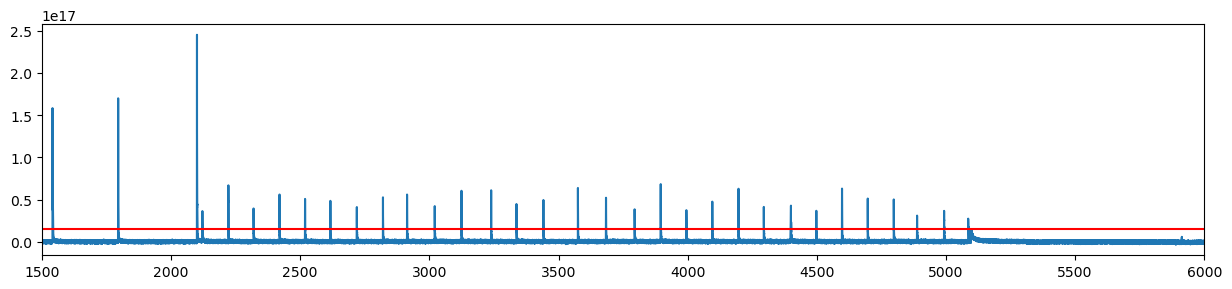

In [18]:
plt.figure(figsize=(15,3))
plt.plot(da['time'],da['data'],'-')
plt.axhline(da_threshold,c='r')
plt.xlim([1500,6000])

In [19]:
def detect_spike_peaks(signal, threshold):
    is_above_threshold = signal > threshold
    edges = np.diff(is_above_threshold.astype(int))
    start_indices = np.where(edges == 1)[0] + 1
    end_indices = np.where(edges == -1)[0] + 1
    if is_above_threshold[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if is_above_threshold[-1]:
        end_indices = np.append(end_indices, len(signal))
    
    peak_indices = []
    for start, end in zip(start_indices, end_indices):
        if start < end:  # check to prevent empty slice errors
            region_max_idx = np.argmax(signal[start:end]) + start
            peak_indices.append(region_max_idx)
    
    return np.array(peak_indices)

(3000.0, 5000.0)

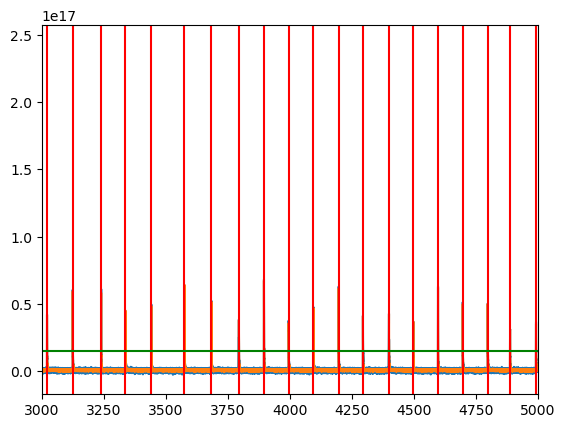

In [20]:
da_win=np.where(da['time']<2000,0,da['data'])
da_win=np.where(da['time']>5000,0,da_win)
da_thr=detect_spike_peaks(apply_savitzky_golay_filter(da_win,50,4),da_threshold)
plt.plot(da['time'],da['data'])
plt.plot(da['time'],apply_savitzky_golay_filter(da['data'],10,4))


elm_time=[]
for idx in da_thr:
    plt.axvline(da['time'][idx],c='r')
    elm_time.append(da['time'][idx])
plt.axhline(da_threshold,c='g')

plt.xlim([3000,5000])


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2., 10., 11.,  3.,  1.,  0.,  1.]),
 array([  0.60009766,   7.25208759,  13.90407753,  20.55606651,
         27.2080574 ,  33.86004639,  40.51203537,  47.16402435,
         53.81601715,  60.46800613,  67.11999512,  73.77198792,
         80.42397308,  87.07596588,  93.72795105, 100.37994385,
        107.03193665, 113.68392181, 120.33591461, 126.98789978,
        133.63989258]),
 <BarContainer object of 20 artists>)

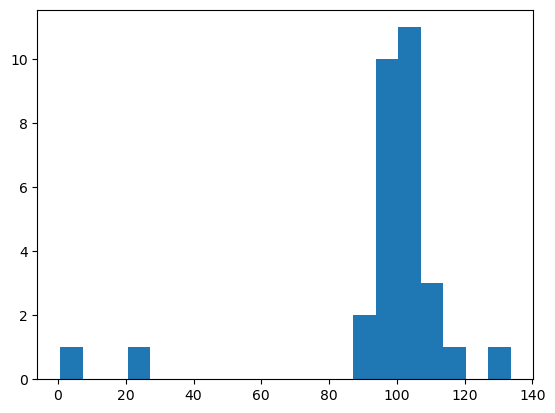

In [21]:
a=np.asarray(elm_time[1:])-np.asarray(elm_time[:-1])
plt.hist(a,bins=20)

In [61]:
def extract_spike_windows(dataframe, peak_times, pre_ms, post_ms):
    # Convert peak times from indices to actual times using the dataframe index
#     peak_times = dataframe.index[peak_indices]
    windows = dict()

    # Extract data around each peak time
    for peakid in range(len(peak_times)-1):
        elm_len = peak_times[peakid+1]-peak_times[peakid]
        if elm_len>40: # check if elm cycle is not too short or too long
            start_time = peak_times[peakid] - pre_ms
            end_time = peak_times[peakid+1] - pre_ms
            # Extract the window of data around the spike
            window = dataframe.loc[start_time:end_time].copy()
            window['real_elm_time']=window.index.to_numpy()
            window.index = (window.index-peak_times[peakid])*100/(elm_len-pre_ms) # normalized elm length
            windows[np.round(peak_times[peakid],2)]=window.copy()
    return windows


# Specify the window in milliseconds before and after the spike
pre_ms = 20
post_ms = 50

# Get the data windows
spike_data_windows_ne = extract_spike_windows(alldfs['ts_core_dens'].mul(1e-19), elm_time, pre_ms, post_ms)
spike_data_windows_te = extract_spike_windows(alldfs['ts_core_temp'].mul(1e-3), elm_time, pre_ms, post_ms)

spike_data_windows_ne_err = extract_spike_windows(alldfs['ts_err_core_dens'].mul(1e-19), elm_time, pre_ms, post_ms)
spike_data_windows_te_err = extract_spike_windows(alldfs['ts_err_core_temp'].mul(1e-3), elm_time, pre_ms, post_ms)

In [62]:
spike_data_windows_ne.keys()

dict_keys([2121.56, 2222.14, 2319.52, 2420.54, 2518.82, 2616.86, 2719.22, 2820.48, 2913.76, 3020.86, 3124.4, 3239.2, 3337.22, 3441.5, 3575.14, 3683.9, 3794.52, 3895.56, 3995.14, 4095.34, 4196.86, 4294.7, 4399.76, 4497.9, 4597.42, 4697.0, 4797.78, 4887.84])

In [63]:
dict_hi_TS = pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/{shotn}_prefinal.pkl','rb'))

srts_df=dict()
srts_df['TS_ne']=pd.DataFrame(dict_hi_TS['L2']['TS_ne']['data'],index=dict_hi_TS['time'])
srts_df['TS_Te']=pd.DataFrame(dict_hi_TS['L2']['TS_Te']['data'],index=dict_hi_TS['time'])

srts_windows_ne = extract_spike_windows(srts_df['TS_ne'], elm_time, pre_ms, post_ms)
srts_windows_te = extract_spike_windows(srts_df['TS_Te'], elm_time, pre_ms, post_ms)


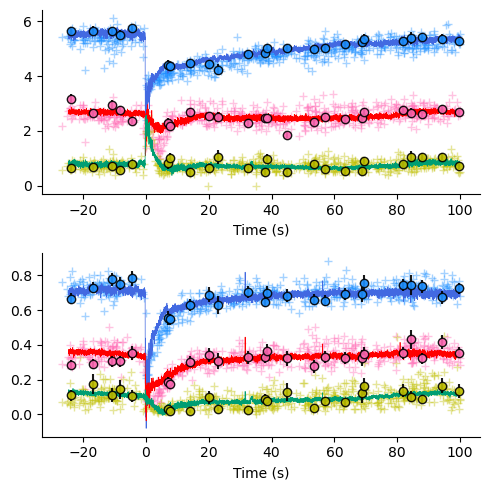

In [65]:
fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(5,5),dpi=100)
chns = [22,15,12]
ax=[]

clr_lst=['dodgerblue','hotpink',cbc['olive']]
# for elm_idx in tqdm(srts_windows_ne.keys()):

#     for i in axs:
#         for j in i:
#             j.cla()
elm_idx = list(spike_data_windows_ne.keys())[16]
# Print the data around each spike for verification
for window_ne, window_te in zip(spike_data_windows_ne.values(), spike_data_windows_te.values()):
    for col_id,cl in zip(chns,clr_lst):
        window_ne[f'ts_core_dens_{col_id+1}'].plot(ax=axs[0],marker='+',linestyle='',mfc = cl,mec=cl,alpha=0.4)
        window_te[f'ts_core_temp_{col_id+1}'].plot(ax=axs[1],marker='+',linestyle='',mfc = cl,mec=cl,alpha=0.4)

for col_id,cl,cl_real in zip(chns,clr_lst,[cbc['blue'],'red',cbc['gn']]):#['b','firebrick','k']):
    axs[0].plot(srts_windows_ne[elm_idx].index,srts_windows_ne[elm_idx][col_id],c=cl_real,linewidth=0.5)
    axs[1].plot(srts_windows_te[elm_idx].index,srts_windows_te[elm_idx][col_id],c=cl_real,linewidth=0.5)
    axs[0].errorbar(spike_data_windows_ne[elm_idx].index,spike_data_windows_ne[elm_idx][f'ts_core_dens_{col_id+1}'],yerr=spike_data_windows_ne_err[elm_idx][f'ts_err_core_dens_{col_id+1}'],marker='o',linestyle='',mfc = cl,mec='k',ecolor='k',alpha=0.9)
    axs[1].errorbar(spike_data_windows_te[elm_idx].index,spike_data_windows_te[elm_idx][f'ts_core_temp_{col_id+1}'],yerr=spike_data_windows_te_err[elm_idx][f'ts_err_core_temp_{col_id+1}'],marker='o',linestyle='',mfc = cl,mec='k',ecolor='k',alpha=0.9)

for i in range(2):
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)


    axs[i].set(xlabel='Time (s)')
    #plt.subplots_adjust(hspace=0.05)

    #plt.savefig(f'{shots[0]}_{shots[1]}_trace.png')
plt.tight_layout()
# plt.savefig('fig3_bottom.svg')

KeyError: 'mse'

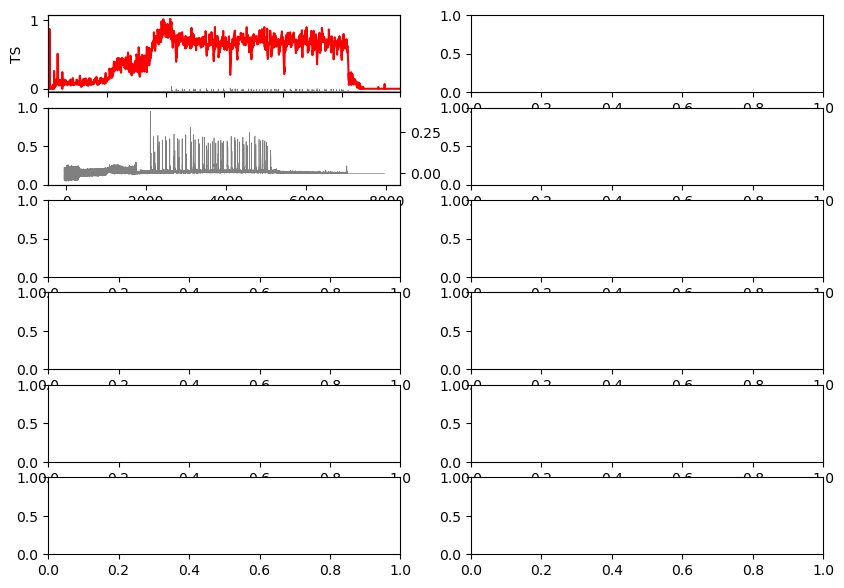

In [12]:
fig,axs=plt.subplots(ncols=2,nrows=6,figsize=(10,7))
dacolor='gray'

for idx,rng in enumerate([[0,6000],[2350,2375]]):
    if idx ==0:
        ls='-'
        ms=None
    else:
        ls=''
        ms='*'
        
    curr_ax=axs[0,idx]
    ax=curr_ax.twinx()
    alldfs['ts_core_temp']['ts_core_temp_20'].apply(lambda x: x*1e-3).plot(ax=curr_ax,color='red',linestyle=ls,marker=ms)

    ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
    #     curr_ax.axvline(x=4095.58,color='g',linestyle='--')
    ax.set(xlim=rng,ylim=[0,5],yticks=[],xticklabels=[])
    curr_ax.set(xlim=rng,ylabel='TS')

    curr_ax=axs[1,idx]
    ax=curr_ax.twinx()
    ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
    alldfs['mse']['25'].plot(ax=curr_ax,color='royalblue',linestyle=ls,marker=ms)
    ax.set(xlim=rng,ylim=[0,5],yticks=[],xticklabels=[])
    curr_ax.set(xlim=rng,ylabel='MSE')


    curr_ax=axs[2,idx]
    ax=curr_ax.twinx()
    ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
    alldfs['fz.t']['q.fz.t46'].plot(ax=curr_ax,color='royalblue',linestyle=ls,marker=ms)
    ax.set(xlim=rng,ylim=[0,5],yticks=[],xticklabels=[])
    curr_ax.set(xlim=rng,ylim=[0,10],ylabel='CER')

    curr_ax=axs[3,idx]
    ax=curr_ax.twinx()
    ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
    alldfs['mag']['b7'].plot(ax=curr_ax,color='royalblue',linestyle='-',marker=None)
    ax.set(xlim=rng,ylim=[0,5],yticks=[],xticklabels=[])
    curr_ax.set(xlim=rng,ylim=[-20,150],ylabel='Magnetics')


    curr_ax=axs[4,idx]
    ax=curr_ax.twinx()
    ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
    alldfs['ece']['ece10'].plot(ax=curr_ax,color='royalblue',linestyle='-',marker=None)
    ax.set(xlim=rng,ylim=[0,5],yticks=[],xticklabels=[])
    curr_ax.set(xlim=rng,ylabel='ECE')

    curr_ax=axs[5,idx]
    ax=curr_ax.twinx()
    ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
    alldfs['co2']['v2'].apply(lambda x: x*1e-14).plot(ax=curr_ax,color='royalblue',linestyle='-',marker=None)
    ax.set(xlim=rng,ylim=[0,5],yticks=[])
    curr_ax.set(xlim=rng,ylim=[0,2.3],ylabel='CO2')
axs[1,1].set(ylim=[-20,100])

In [ ]:
alldfs['mse']

In [7]:
shotn = 157545
dfs=pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/shared/150k_island/{shotn}_processed.pkl','rb'))

final_df = pd.DataFrame(index=dfs['ece'].index.astype(np.float32)) # use the time of first channel of ECE as reference 

for k in ['ts_core_dens', 'ts_core_temp', 'ece', 'co2', 'ts_err']:
    final_df=pd.merge_asof(final_df, dfs[k].astype(np.float32), left_index=True, right_index=True) #Merge all ECE-CO2 channel     
    
final_df.dropna(inplace=True)
final_df=final_df.iloc[::100,:]

ece_loc={157545:[0.908785, 0.838104, 0.775168, 0.717171, 0.663316, 0.613011, 0.56567, 0.521046, 0.478783, 0.438717, 0.400556, 0.364173, 0.329422, 0.296122, 0.264161, 0.233426, 0.233426, 0.233426, 0.203857, 0.175378, 0.147938, 0.121511, 0.0961902, 0.0722199, 0.0504034, 0.033525, -0.00491042, -0.0405697, -0.0586711, -0.078645, -0.0990409, -0.119399, -0.139546, -0.1592745, -0.179003, -0.217266, -0.254387, -0.29033, -0.325241, -0.359123],
         174823:[1.11449, 1.08285, 1.05004, 1.01571, 0.946913, 0.866202, 0.796481, 0.734424, 0.678476, 0.627061, 0.57963, 0.535342, 0.493748, 0.454532, 0.417359, 0.417359, 0.417359, 0.381964, 0.348135, 0.315708, 0.284549, 0.254528, 0.225564, 0.197629, 0.170622, 0.144511, 0.119329, 0.0952836, 0.0726352, 0.0524111, 0.0381741, -0.0336913, -0.0476999, -0.0617085, -0.100823, -0.140747, -0.179992, -0.218246, -0.255405, -0.291502]}

[(3500.0, 4500.0), (0.0, 10.0), Text(0, 0.5, 'CER')]

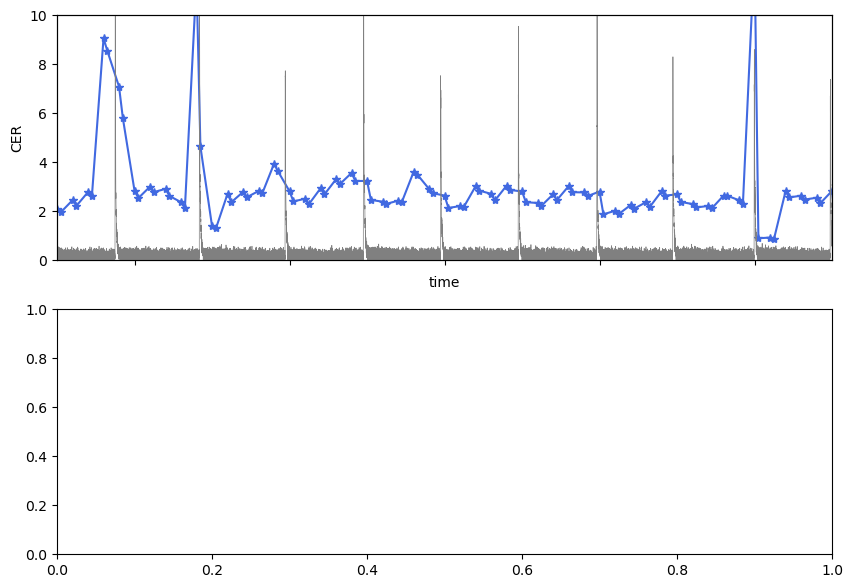

In [14]:
fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(10,7))
idx=1
curr_ax=axs[0]
ax=curr_ax.twinx()
ax.plot(da['time'],da['data']*1e-16,color=dacolor,linewidth=0.5)
alldfs['fz.t']['q.fz.t46'].plot(ax=curr_ax,color='royalblue',linestyle='-',marker=ms)
ax.set(xlim=rng,ylim=[0,5],yticks=[],xticklabels=[])
curr_ax.set(xlim=rng,ylim=[0,10],ylabel='CER')

(2000.0, 5000.0)

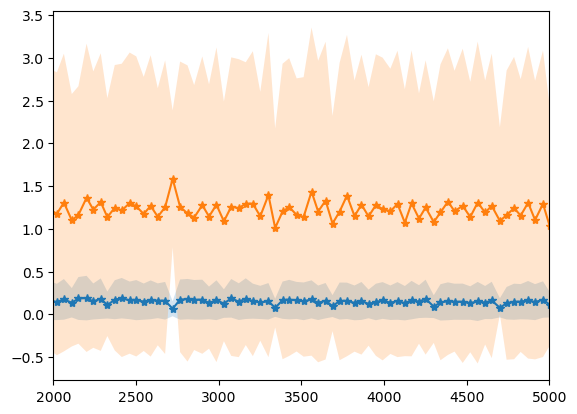

In [10]:
mystd=np.std(alldfs['ts_core_temp'].iloc[:,:20]*1e-3,axis=1).to_numpy()
mymean=np.mean(alldfs['ts_core_temp'].iloc[:,:20]*1e-3,axis=1).to_numpy()
mytime=alldfs['ts_core_temp'].index.to_numpy()
smp=10
plt.plot(mytime[::smp],mymean[::smp],'-*')
plt.fill_between(mytime[::smp],mymean[::smp]-mystd[::smp],mymean[::smp]+mystd[::smp], alpha=0.2)
plt.xlim([1000,3000])

mystd=np.std(alldfs['ts_core_dens'].iloc[:,:20]*1e-19,axis=1).to_numpy()
mymean=np.mean(alldfs['ts_core_dens'].iloc[:,:20]*1e-19,axis=1).to_numpy()
mytime=alldfs['ts_core_dens'].index.to_numpy()
smp=10
plt.plot(mytime[::smp],mymean[::smp],'-*')
plt.fill_between(mytime[::smp],mymean[::smp]-mystd[::smp],mymean[::smp]+mystd[::smp], alpha=0.2)
plt.xlim([2000,5000])

In [11]:
signame='mags'
mystd=np.std(alldfs[signame].iloc[:,::2],axis=1).to_numpy()
mymean=np.mean(alldfs[signame].iloc[:,::2],axis=1).to_numpy()
mytime=alldfs[signame].index.to_numpy()
smp=100000
plt.plot(mytime[::smp],mymean[::smp],'-*')
plt.fill_between(mytime[::smp],mymean[::smp]-mystd[::smp],mymean[::smp]+mystd[::smp], alpha=0.2)
plt.xlim([2000,5000])

KeyError: 'mags'

In [ ]:
signame='mags'
mystd=np.std(alldfs[signame].iloc[1000:2000,:],axis=1).to_numpy()
mymean=np.mean(alldfs[signame].iloc[:,::2],axis=1).to_numpy()
mytime=alldfs[signame].index.to_numpy()
smp=100000
plt.plot(mytime[::smp],mymean[::smp],'-*')
plt.fill_between(mytime[::smp],mymean[::smp]-mystd[::smp],mymean[::smp]+mystd[::smp], alpha=0.2)
plt.xlim([2000,5000])

In [ ]:
mystd=np.std(alldfs['ece'].iloc[1000000:2000000,:],axis=0).to_numpy()
mymean=np.mean(alldfs['ece'].iloc[1000000:2000000,:],axis=0).to_numpy()
myloc=ece_loc[shotn]


plt.plot(myloc,mymean,'-*')
plt.fill_between(myloc,mymean-mystd,mymean+mystd, alpha=0.2)
plt.xlim([0,1])

In [ ]:
mystd=np.nanstd(alldfs['mags'].iloc[2000000:4000000,:],axis=0)
mymean=np.nanmean(alldfs['mags'].iloc[2000000:4000000,:],axis=0)
myloc=ece_loc[shotn]


plt.plot(mymean,'-*')
plt.fill_between(range(8),mymean-mystd,mymean+mystd, alpha=0.2)
# plt.xlim([0,1])

In [20]:
with h5py.File('/scratch/gpfs/EKOLEMEN/big_d3d_data/170000/174823_mse.h5.h5','r') as hf:
    a=np.asarray(hf['q.fz.t11']['zdata'])

<KeysViewHDF5 ['xdata', 'xunits', 'ydata', 'yunits', 'zdata', 'zunits']>


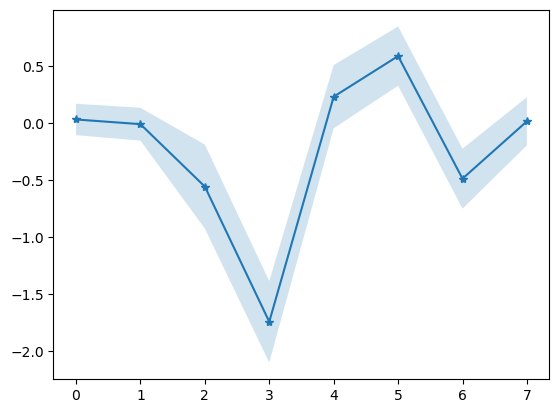

In [36]:
signame='mag'
mystd=np.std(alldfs[signame].iloc[1000:1500,:],axis=0).to_numpy()
mymean=np.mean(alldfs[signame].iloc[1000:1500,:],axis=0).to_numpy()
mytime=alldfs[signame].index.to_numpy()
plt.plot(range(8),mymean,'-*')
plt.fill_between(range(8),mymean-mystd,mymean+mystd, alpha=0.2)
# plt.xlim([2000,5000])

In [61]:
with h5py.File('/scratch/gpfs/EKOLEMEN/big_d3d_data/170000/174823_profiles.h5','r') as hf:
#     print(hf.keys())
    data=np.asarray(hf['etempfit']['zdata'])
    tm=np.asarray(hf['etempfit']['ydata'])
    loc=np.asarray(hf['etempfit']['xdata'])

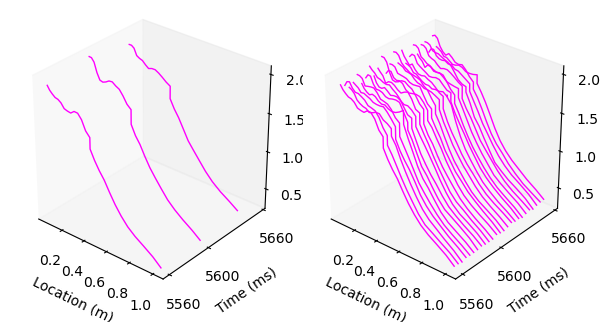

In [46]:
ts=dict()
with h5py.File('/scratch/gpfs/EKOLEMEN/big_d3d_data/170000/174823_ts.h5','r') as hf:
    ts['data']=np.asarray(hf['core.temp']['zdata'])*1.e-3
    ts['tm']=np.asarray(hf['core.temp']['xdata'])
    
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/170000/174823_ts_rz.h5','r') as hf:
    TS_Z=np.asarray(hf['core.z']['zdata'])

temp=dict()
with h5py.File('/scratch/gpfs/EKOLEMEN/big_d3d_data/170000/174823_profiles.h5','r') as hf:
    temp['data']=np.asarray(hf['etempfit']['zdata'])*1.e-3
    temp['tm']=np.asarray(hf['etempfit']['ydata'])
    temp['loc']=np.asarray(hf['etempfit']['xdata'])

ece_loc = [1.11449, 1.08285, 1.05004, 1.01571, 0.946913, 0.866202, 0.796481, 0.734424, 0.678476, 0.627061, 0.57963, 0.535342, 0.493748, 0.454532, 0.417359, 0.417359, 0.417359, 0.381964, 0.348135, 0.315708, 0.284549, 0.254528, 0.225564, 0.197629, 0.170622, 0.144511, 0.119329, 0.0952836, 0.0726352, 0.0524111, 0.0381741, -0.0336913, -0.0476999, -0.0617085, -0.100823, -0.140747, -0.179992, -0.218246, -0.255405, -0.291502]

fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(6,6),subplot_kw={'projection': '3d'})

# # Example data
# x = ts['tm'][1609:1632].copy()
# y = TS_Z[:40].copy()
# X, Y = np.meshgrid(x, y)
# Z = ts['data'][:40,1609:1632].copy()



# for col_index in np.arange(0,len(x),30):
#     line = axs[0,0].plot(y, np.full_like(y,x[col_index]), apply_savitzky_golay_filter(Z[:, col_index],5,2),color='orange', linewidth=1)

# for col_index in np.arange(0,len(x),5):
#     line = axs[0,1].plot(y, np.full_like(y,x[col_index]), apply_savitzky_golay_filter(Z[:, col_index],5,2),color='orange', linewidth=1)


# Example data
x = alldfs['ece'].index.to_numpy()[2805000:2855000:100]
y = ece_loc [3:30]
X, Y = np.meshgrid(x, y)
Z = alldfs['ece'].iloc[2805000:2855000:100,3:30].to_numpy().T



for col_index in np.arange(0,len(x),200):
    line = axs[0].plot(y, np.full_like(y,x[col_index]), apply_savitzky_golay_filter(Z[:, col_index],5,2),color='magenta', linewidth=1)

for col_index in np.arange(0,len(x),20):
    line = axs[1].plot(y, np.full_like(y,x[col_index]), apply_savitzky_golay_filter(Z[:, col_index],5,2),color='magenta', linewidth=1)


for i in range(2):
    axs[i].view_init(elev=30, azim=-50, roll=0)
    axs[i].set(box_aspect=[1, 1, 1],xlabel='Location (m)',ylabel='Time (ms)',yticks=[5560,5600,5660])
    axs[i].grid(False)

    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

    #plt.subplots_adjust(hspace=0.05)

    #plt.savefig(f'{shots[0]}_{shots[1]}_trace.png')
plt.tight_layout()
plt.savefig('fig1_diag.svg')

        

In [26]:
np.argmin(np.abs(alldfs['ece'].index-5560))

2805000

[Text(0, 0.5, 'MSE')]

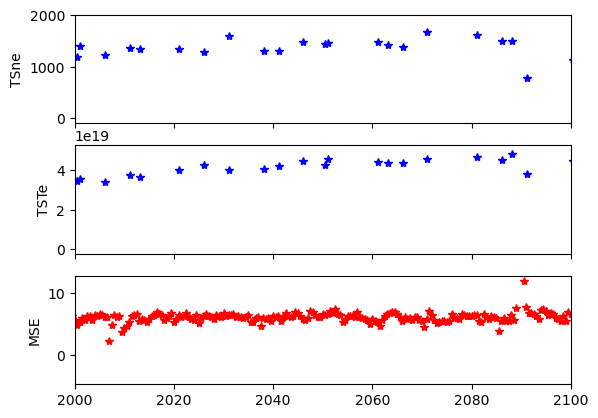

In [63]:
shotn = 157545

with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_ts.h5','r') as hf:
    tst={'data':np.array(hf['core.temp']['zdata']),
        'time':np.array(hf['core.temp']['xdata'])
    }
    tsn={'data':np.array(hf['core.dens']['zdata']),
        'time':np.array(hf['core.dens']['xdata'])
    }
        
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_mse.h5','r') as hf:
    mse={'data':np.array(hf['01']['zdata']),
        'time':np.array(hf['01']['xdata'])
    }
    
idx=25
fig,axs=plt.subplots(nrows=3,ncols=1,sharex=True)
axs[0].plot(tst['time'],tst['data'][idx,:],'b*')
axs[1].plot(tsn['time'],tsn['data'][idx,:],'b*')
axs[2].plot(mse['time'],mse['data'],'r*')
axs[0].set(xlim=[2000,2100],ylabel='TSne')
axs[1].set(ylabel='TSTe')
axs[2].set(ylabel='MSE')

In [65]:
1000/np.mean(mse['time'][1:]-mse['time'][:-1])

1999.3091465776417

In [4]:
final_data = pickle.load(open('final_profile_157545.pkl','rb'))

rad=np.asarray([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.09999999, 0.11      , 0.12      , 0.13      , 0.14      ,
       0.14999999, 0.16      , 0.17      , 0.17999999, 0.19      ,
       0.19999999, 0.21      , 0.22      , 0.22999999, 0.24      ,
       0.25      , 0.26      , 0.26999998, 0.28      , 0.29      ,
       0.29999998, 0.31      , 0.32      , 0.32999998, 0.34      ,
       0.35      , 0.35999998, 0.37      , 0.38      , 0.39      ,
       0.39999998, 0.41      , 0.42      , 0.42999998, 0.44      ,
       0.45      , 0.45999998, 0.47      , 0.48      , 0.48999998,
       0.5       , 0.51      , 0.52      , 0.53      , 0.53999996,
       0.55      , 0.56      , 0.57      , 0.58      , 0.59      ,
       0.59999996, 0.61      , 0.62      , 0.63      , 0.64      ,
       0.65      , 0.65999997, 0.66999996, 0.68      , 0.69      ,
       0.7       , 0.71      , 0.71999997, 0.72999996, 0.74      ,
       0.75      , 0.76      , 0.77      , 0.78      , 0.78999996,
       0.79999995, 0.81      , 0.82      , 0.83      , 0.84      ,
       0.84999996, 0.85999995, 0.87      , 0.88      , 0.89      ,
       0.9       , 0.90999997, 0.91999996, 0.93      , 0.94      ,
       0.95      , 0.96      , 0.96999997, 0.97999996, 0.98999995])

In [9]:
strt,endd = [2000,2150]

def times(x,strt,endd):
    a=np.argmin(np.abs(x-strt))
    b=np.argmin(np.abs(x-endd))
    return (a,b)

final_figure=dict()

final_figure['ece']={'time':dfs['ece'].index[2774999:2824999].to_numpy(),
     'data':dfs['ece'].iloc[2774999:2824999,:].to_numpy(),
     'loc':np.hstack([0.908785, 0.838104, 0.775168, 0.717171, 0.663316, 0.613011, 0.56567, 0.521046, 0.478783, 0.438717, 0.400556, 0.364173, 0.329422, 0.296122, 0.264161, 0.233426, 0.233426, 0.233426, 0.203857, 0.175378, 0.147938, 0.121511, 0.0961902, 0.0722199, 0.0504034, 0.033525, -0.00491042, -0.0405697, -0.0586711, -0.078645, -0.0990409, -0.119399, -0.139546, -0.1592745, -0.179003, -0.217266, -0.254387, -0.29033, -0.325241, -0.359123])
}

final_figure['co2']={'time':dfs['co2'].index[9249999:9416666].to_numpy(),
     'data':dfs['co2'].iloc[9249999:9416666,:].to_numpy(),
     'loc':['r0','v1','v2','v3']
    }


final_figure['mag']={'time':dfs['mags'].index[8100000:8300000].to_numpy(),
     'data':dfs['mags'].iloc[8100000:8300000,:].to_numpy(),
     'loc':[f'b{i+1}' for i in range(8)]
    }

final_figure['TS'] ={'original':{'time':dfs['ts_core_dens'].index[1166:1187].to_numpy(),
                 'ts_te':dfs['ts_core_temp'].iloc[1166:1187,:40].to_numpy(),
                 'ts_ne':dfs['ts_core_dens'].iloc[1166:1187,:40].to_numpy(),
                 'loc_z(m)':final_data['TS']['TS_Z'][:40].copy()
    
},
     'superres':{'time':final_data['TS']['time'][26250:26750].copy(),
                 'ts_te':final_data['TS']['L2']['TS_Te']['data'][26250:26750,:].copy(),
                 'ts_ne':final_data['TS']['L2']['TS_ne']['data'][26250:26750,:].copy(),
                'loc_z(m)':final_data['TS']['TS_Z'][:40].copy()},
}

final_figure['profile']={'original':{'time':dfs['edensfit'].index[262:267].to_numpy(),
                 'te':dfs['etempfit'].iloc[262:267,:100].to_numpy(),
                 'ne':dfs['edensfit'].iloc[262:267,:100].to_numpy(),
                 'loc':rad.copy()
    
},
      'superres':{'time':final_data['time'][:,0],
                  'te':final_data['Te'].copy(),
                  'ne':final_data['ne'].copy(),
                  'loc':final_data['rpsin']
          
      }
     }

NameError: name 'dfs' is not defined

Text(0.5, 1.0, '5550.53 - 5550.00')

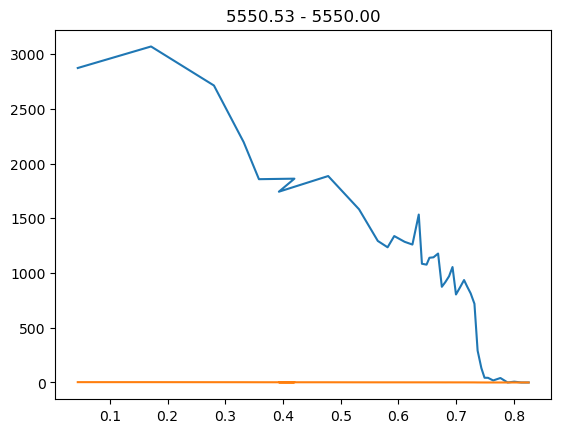

In [8]:
tm = 2050
idx1 = np.argmin(np.abs(final_figure['TS']['original']['time']-tm))
idx2 = np.argmin(np.abs(final_figure['TS']['superres']['time']-tm))
plt.plot(final_figure['TS']['original']['loc_z(m)'],final_figure['TS']['original']['ts_te'][idx1,:])
plt.plot(final_figure['TS']['superres']['loc_z(m)'],final_figure['TS']['superres']['ts_te'][idx2,:])
plt.title('%.2f - %.2f' % ( final_figure['TS']['original']['time'][idx1],final_figure['TS']['superres']['time'][idx2]))

In [126]:
# pickle.dump(final_figure,open('157545_data_for_figure.pkl','wb'))

In [8]:
shotn = 157545
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_basic.h5', 'r') as actu_file:
    da={'time':np.asarray(actu_file['fs00']['xdata']),
        'data':np.asarray(actu_file['fs00']['zdata'])}

(2000.0, 3000.0)

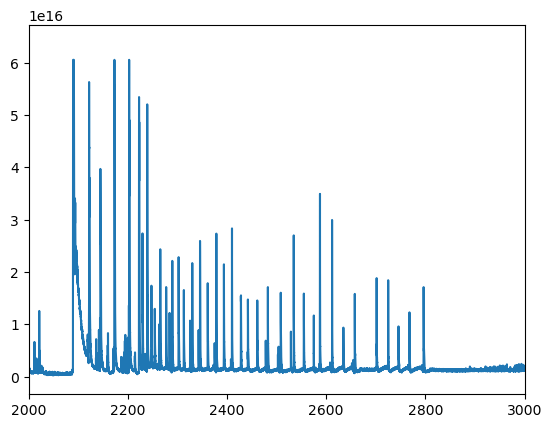

In [12]:
plt.plot(da['time'],da['data'])
plt.xlim([2000,3000])

In [45]:
# flist = glob.glob('/scratch/gpfs/EKOLEMEN/aj17/shared/*_diag_prof.pkl')
shotlist = [190347, 174823, 153764,190346, 178636, 190348]

data=dict()

shotn = 153761
pref=shotn-np.mod(shotn,10000)

# hf=h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_profiles.h5','r')
# data['dens']= {'time':np.asarray(hf['edensfit']['ydata']),
#       'loc':np.asarray(hf['edensfit']['xdata']),
#       'data':np.asarray(hf['edensfit']['zdata'])}

# data['temp']= {'time':np.asarray(hf['etempfit']['ydata']),
#       'loc':np.asarray(hf['etempfit']['xdata']),
#       'data':np.asarray(hf['etempfit']['zdata'])}
# hf.close()

# with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_actu.h5', 'r') as actu_file:
#     data['rmp']={'time':np.asarray(actu_file['iu90']['xdata']),
#         'data':np.asarray(actu_file['iu90']['zdata'])}



with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_ts.h5','r') as hf:    
    data['ts']={'data':np.asarray(hf['core.dens']['zdata'])[10,:]*1e-19,
        'time':np.asarray(hf['core.dens']['xdata'])}
    
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_cer.h5','r') as hf:    
    data['cer']={'data':np.asarray(hf['q.nz.t23']['zdata'])*1e-18,
    'time':np.asarray(hf['q.nz.t23']['xdata'])}
    
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_mse.h5','r') as hf:    
    data['mse']={'data':np.asarray(hf['10']['zdata']),
    'time':np.asarray(hf['10']['xdata'])}

    
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_ece_cali.h5','r') as hf:
    data['ece']={'data':np.asarray(hf['zdata'][22,:]),
        'time':np.asarray(hf['xdata'])}


with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_co2_den.h5','r') as hf:    
    data['co2']={'data':np.asarray(hf['v1']['zdata'])*1e-14,
    'time':np.asarray(hf['v2']['xdata'])}

with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_mag_hi.h5','r') as hf:    
    data['mag']={'data':np.asarray(hf['b7']['zdata']),
    'time':np.asarray(hf['b7']['xdata'])}

# with open(f'/scratch/gpfs/EKOLEMEN/aj17/b_{shotn}.pkl','rb') as fid:  
#     mag = pickle.load(fid,encoding='latin1')
#     data['mag']={'data':mag[1:3,:].T,
#     'time':mag[0,:]}


with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_basic.h5', 'r') as actu_file:
    data['da']={'time':np.asarray(actu_file['fs00']['xdata']),
        'data':np.asarray(actu_file['fs00']['zdata'])*1e-17}



FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/scratch/gpfs/EKOLEMEN/big_d3d_data/150000/153761_ts.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

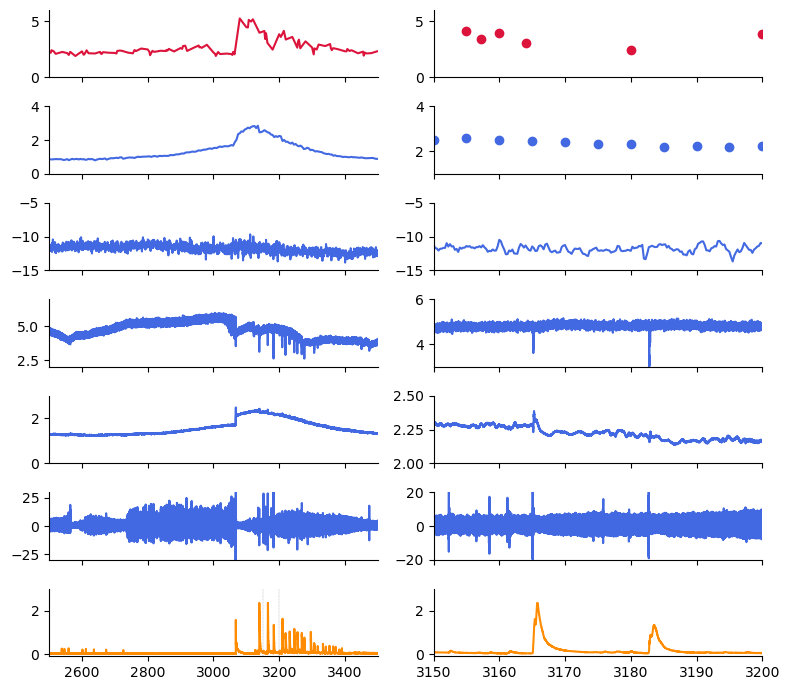

In [39]:
fig,axs=plt.subplots(ncols=2,nrows=len(data),figsize=(8,7),sharex='col')

rng1={'da':[-.1,3],
    'ece':[2,7],
    'ts':[0,6],
    'co2':[0,3],
    'mag':[-30,30],
     'mse':[-15,-5],
    'cer':[0,4]}

rng2={'da':[-.1,3],
    'ece':[3,6],
    'ts':[0,6],
    'co2':[2,2.5],
    'mag':[-20,20],
     'mse':[-15,-5],
    'cer':[1,4]}

clr={'da':'darkorange',
    'ece':cbc['blue'],
    'ts':cbc['red'],
    'co2':cbc['blue'],
    'mag':cbc['blue'],
     'mse':cbc['blue'],
    'cer':cbc['blue']}


idx=0
for k,v in data.items():
    frq = 1/np.mean(v['time'][1:]-v['time'][:-1])
    if frq > 1:
        fmt = '-'
    else:
        fmt='o'
    axs[idx,0].plot(v['time'],v['data'],'-',c=clr[k])
    axs[idx,0].set(xlim=[2500,3500],ylim=rng1[k])
    
    axs[idx,1].plot(v['time'],v['data'],fmt,c=clr[k])
    axs[idx,1].set(xlim=[3150,3200],ylim=rng2[k])
    
    axs[idx,0].spines['right'].set_visible(False)
    axs[idx,0].spines['top'].set_visible(False)
    axs[idx,1].spines['right'].set_visible(False)
    axs[idx,1].spines['top'].set_visible(False)
    idx+=1

axs[idx-1,0].axvline(x=3150,c='gray',linestyle='--',linewidth=0.2)
axs[idx-1,0].axvline(x=3200,c='gray',linestyle='--',linewidth=0.2)
plt.tight_layout()
plt.savefig('fig5.svg')


In [40]:
with h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{pref}/{shotn}_ece_cali.h5','r') as hf:
    D=np.asarray(hf['zdata'])
    T=np.asarray(hf['xdata'])
                

(3.0, 6.0)

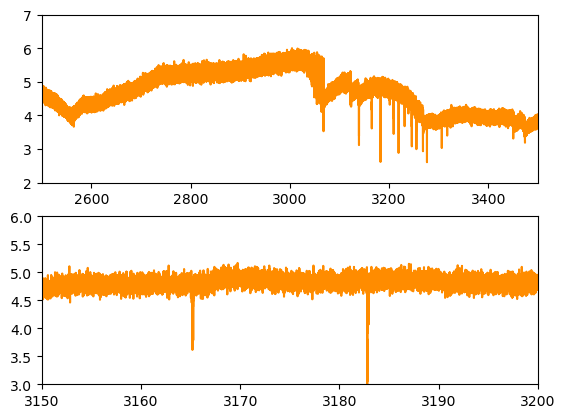

In [36]:
ddd=D[22,:]
plt.subplot(211)
plt.plot(T,ddd,'-',c=clr[k])
plt.xlim([2500,3500])
plt.ylim([2,7])
plt.subplot(212)
plt.plot(T,ddd,'-',c=clr[k])
plt.xlim([3150,3200])
plt.ylim([3,6])


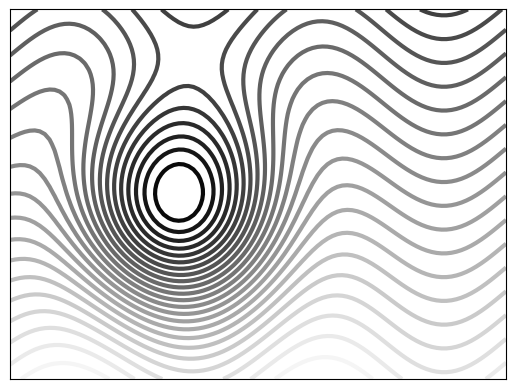

In [21]:
z = np.load('heights-2.npy')
plt.contour(np.transpose(z),np.linspace(z.min(),z.max(),25),cmap='gray',linewidths=3) 
plt.xticks([])
plt.yticks([])
plt.savefig('myFig2.svg', format='svg')


In [67]:
err=pickle.load(open('error_measured_pred_150k.pkl','rb'))
data=dict()
for shotn in [153764,157545,174823,190347]:
    data[shotn] = pickle.load(open(f'{shotn}_temp.pkl','rb'))

In [68]:
shotlist=list(err['error_pred'].keys())
# shotlist = [153764,157545,174823,190347]
TS_Z=dict()
for shotn in shotlist:
    main_path=f'../data/diag2diag-data/'
    # with h5py.File(f'{main_path}{shotn}_ts_rz.h5','r') as hf:
    #     tsz=np.asarray(hf['core.z']['zdata'])
    with h5py.File(f'{main_path}{shotn}_ts.h5','r') as hf:
        tsz=np.asarray(hf['tsne_core']['tsne_core_ydata'])      
        ts_z_sort=sorted(range(len(tsz)), key=lambda k: tsz[k])[1:]
        ts_z_sort = filter(lambda k: k < 40, ts_z_sort)
        ts_z_sort = list(ts_z_sort)
        TS_Z[shotn]={'data':tsz,'order':ts_z_sort}

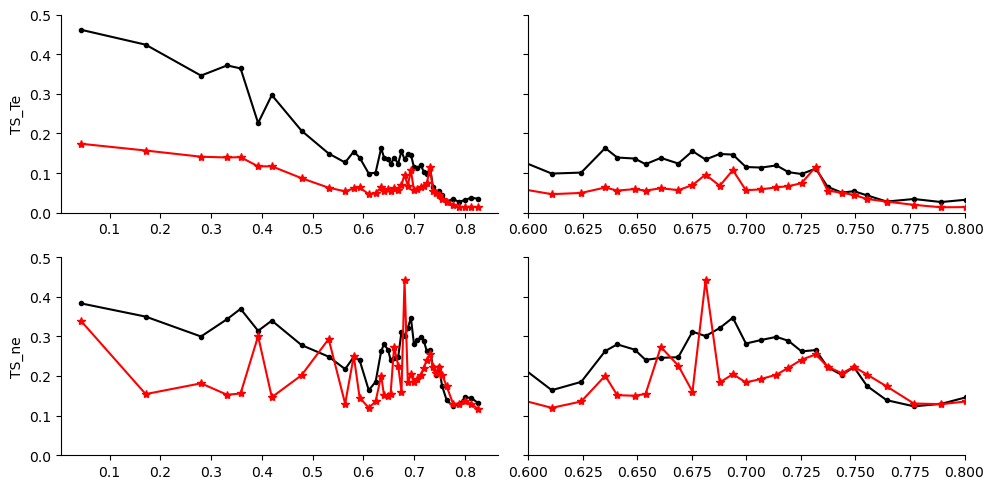

In [128]:
fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(10,5),sharey=True)

for idx,ts_nm in enumerate(['TS_Te','TS_ne']):
    a=np.vstack([err['error_measured'][shotn][ts_nm][:,TS_Z[shotn]['order']][err['error_pred'][shotn]['time']<4000,:] for shotn in shotlist])
    b=np.vstack([err['error_pred'][shotn][ts_nm][:,TS_Z[shotn]['order']][err['error_pred'][shotn]['time']<4000,:] for shotn in shotlist])
    a=np.sqrt(np.mean(np.power(a,2),axis=0,where=a>0))
    b=np.sqrt(np.mean(np.power(b,2),axis=0,where=b>0))
    axs[idx,0].plot(TS_Z[shotn]['data'][TS_Z[shotn]['order']],a,'.-k')
    axs[idx,0].plot(TS_Z[shotn]['data'][TS_Z[shotn]['order']],b,'*-r')
    axs[idx,0].set(ylim=[0,0.5],ylabel=ts_nm)

    axs[idx,1].plot(TS_Z[shotn]['data'][TS_Z[shotn]['order']],a,'.-k')
    axs[idx,1].plot(TS_Z[shotn]['data'][TS_Z[shotn]['order']],b,'*-r')
    axs[idx,1].set(xlim=[0.6,0.8],ylim=[0,0.5])

    for i in range(2):
        axs[idx,i].spines['right'].set_visible(False)
        axs[idx,i].spines['top'].set_visible(False)


plt.tight_layout()

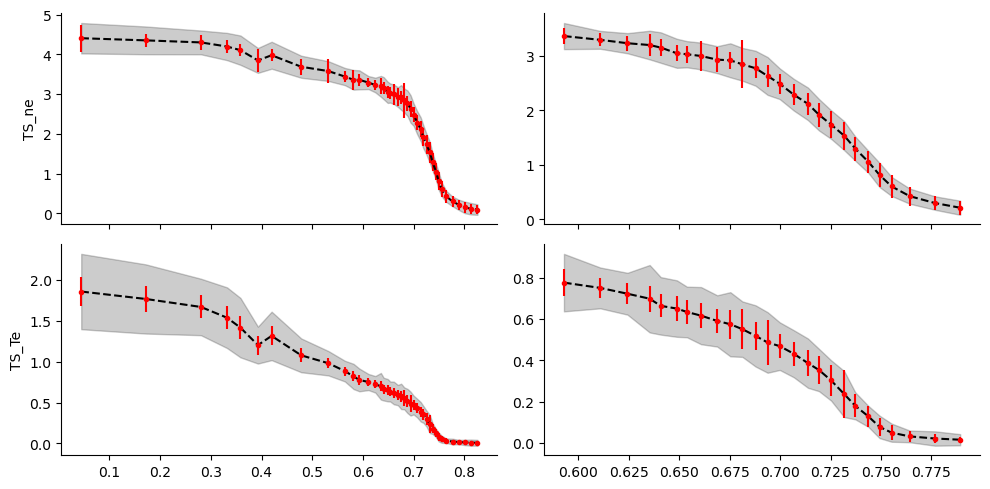

In [69]:
shotlist=list(err['error_pred'].keys())
# shotlist=list(data.keys())

fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(10,5),sharex='col')
zoom_rng=[11,37]
for idx,ts_nm in enumerate(['TS_ne','TS_Te']):
    a=np.vstack([err['error_measured'][shotn][ts_nm][:,TS_Z[shotn]['order']][err['error_pred'][shotn]['time']<4000,:] for shotn in shotlist])
    b=np.vstack([err['error_pred'][shotn][ts_nm][:,TS_Z[shotn]['order']][err['error_pred'][shotn]['time']<4000,:] for shotn in shotlist])
    a=np.sqrt(np.mean(np.power(a,2),axis=0,where=a>0))
    b=np.sqrt(np.mean(np.power(b,2),axis=0,where=b>0))
    c=np.mean(np.vstack([np.mean(v['truth'][ts_nm],axis=0) for v in data.values()]),axis=0)
    c=moving_average(c,5)
    d=np.mean(np.vstack([np.mean(v['avg']['L2'][ts_nm],axis=0) for v in data.values()]),axis=0)
    d=moving_average(d,5)
    axs[idx,0].fill_between(TS_Z[shotn]['data'][TS_Z[shotn]['order']],c[TS_Z[shotn]['order']]-a,c[TS_Z[shotn]['order']]+a,alpha=0.2,color='k',label='Measured')
    axs[idx,0].errorbar(TS_Z[shotn]['data'][TS_Z[shotn]['order']],d[TS_Z[shotn]['order']],yerr=b,fmt='.',color='red',label='Reconstructed')
    axs[idx,0].set(ylabel=ts_nm)
    axs[idx,0].plot(TS_Z[shotn]['data'][TS_Z[shotn]['order']],c[TS_Z[shotn]['order']],'--k')

    axs[idx,1].fill_between(TS_Z[shotn]['data'][TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]],c[TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]]-a[zoom_rng[0]:zoom_rng[1]],c[TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]]+a[zoom_rng[0]:zoom_rng[1]],alpha=0.2,color='k',label='Measured')
    axs[idx,1].errorbar(TS_Z[shotn]['data'][TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]],c[TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]],yerr=b[zoom_rng[0]:zoom_rng[1]],fmt='.',color='red',label='Reconstructed')
    axs[idx,1].plot(TS_Z[shotn]['data'][TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]],c[TS_Z[shotn]['order'][zoom_rng[0]:zoom_rng[1]]],'--k')


    for i in range(2):
        axs[idx,i].spines['right'].set_visible(False)
        axs[idx,i].spines['top'].set_visible(False)


plt.tight_layout()
# plt.savefig('myFig2.svg', format='svg')


In [3]:
shotlist = [153764, 157543, 157542, 157537, 157532, 157538, 157544, 157536, 157539, 157546, 157533, 157540, 157535, 157545, 190347,174823, 157534] #174823#,153764,157545,ç,190347
err={x:dict() for x in shotlist}
for shotn in shotlist:
    with open(f'../data/diag2diag-data/nature-paper-data/{shotn}_UQ.pkl','rb') as fid:
        tmp=pickle.load(fid)
        err[shotn]=tmp[shotn]

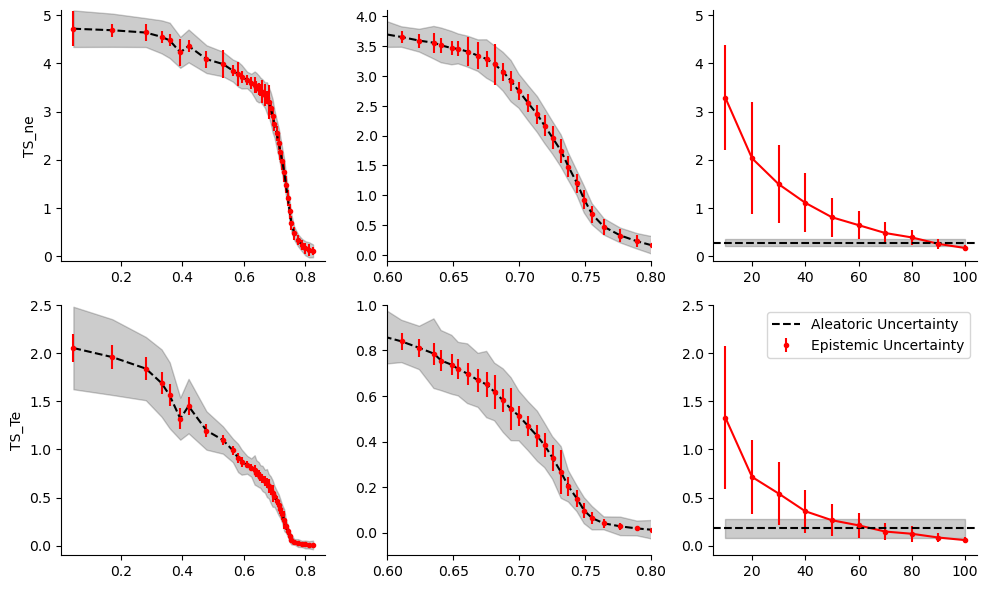

In [26]:
coeff=2
fig,axs=plt.subplots(ncols=3,nrows=2,figsize=(10,6))
shotlist_error=[153764, 157543, 157542, 157537, 157532, 157538, 157544, 157536, 157539, 157546, 157533, 157540, 157535, 174823]
shotlist_data=[153764, 157545, 174823, 190347]
A={key: None for key in ['TS_ne','TS_Te']}
for idx,ts_nm in enumerate(['TS_ne','TS_Te']):
    a = np.vstack([err[shotn]['measured'][ts_nm]['err'][err[shotn]['measured'][ts_nm]['time']<4000,:][:,err[shotn]['TS_Z'][ts_nm]['order'][-40:]] for shotn in shotlist_error])*coeff
    A[ts_nm]=a.copy()
    b = np.vstack([err[shotn]['pred'][ts_nm]['err'][err[shotn]['pred'][ts_nm]['time']<4000,:][:,err[shotn]['TS_Z'][ts_nm]['order'][-40:]] for shotn in shotlist_error])*coeff

    a=np.sqrt(np.mean(np.power(a,2),axis=0,where=a>0))
    b=np.sqrt(np.mean(np.power(b,2),axis=0,where=b>0))

    c = np.vstack([err[shotn]['measured'][ts_nm]['data'][err[shotn]['measured'][ts_nm]['time']<4000,:40] for shotn in shotlist_data]) #[157545, 157534, 174823, 190347]
    c=np.mean(c,axis=0)
    c=moving_average(c,5)

    d=np.vstack([err[shotn]['pred'][ts_nm]['data'][err[shotn]['pred'][ts_nm]['time']<4000,:40] for shotn in shotlist_data])
    d=np.mean(d,axis=0)
    d=moving_average(d,5)

    axs[idx,0].fill_between(err[shotn]['TS_Z'][ts_nm]['data'][err[shotn]['TS_Z'][ts_nm]['order'][-40:]],c[err[shotn]['TS_Z'][ts_nm]['order'][-40:]]-a,c[err[shotn]['TS_Z'][ts_nm]['order'][-40:]]+a,alpha=0.2,color='k',label='Measured')
    axs[idx,0].errorbar(err[shotn]['TS_Z'][ts_nm]['data'][err[shotn]['TS_Z'][ts_nm]['order'][-40:]],d[err[shotn]['TS_Z'][ts_nm]['order'][-40:]],yerr=b,fmt='.',color='red',label='Reconstructed')
    axs[idx,0].plot(err[shotn]['TS_Z'][ts_nm]['data'][err[shotn]['TS_Z'][ts_nm]['order'][-40:]],c[err[shotn]['TS_Z'][ts_nm]['order'][-40:]],'--k')

    axs[idx,1].fill_between(err[shotn]['TS_Z'][ts_nm]['data'][err[shotn]['TS_Z'][ts_nm]['order'][-40:]],c[err[shotn]['TS_Z'][ts_nm]['order'][-40:]]-a,c[err[shotn]['TS_Z'][ts_nm]['order'][-40:]]+a,alpha=0.2,color='k',label='Measured')
    axs[idx,1].errorbar(err[shotn]['TS_Z'][ts_nm]['data'][err[shotn]['TS_Z'][ts_nm]['order'][-40:]],d[err[shotn]['TS_Z'][ts_nm]['order'][-40:]],yerr=b,fmt='.',color='red',label='Reconstructed')
    axs[idx,1].set(xlim=[0.6,0.8])
    axs[idx,1].plot(err[shotn]['TS_Z'][ts_nm]['data'][err[shotn]['TS_Z'][ts_nm]['order'][-40:]],c[err[shotn]['TS_Z'][ts_nm]['order'][-40:]],'--k')

chn_rng=[0,40]
for idx,ts_nm in enumerate(['TS_ne','TS_Te']):
    uq=[]
    A[ts_nm]=A[ts_nm][:,chn_rng[0]:chn_rng[1]]
    for i in np.arange(0.1,1.1,0.1):
        b=pickle.load(open(f'../data/diag2diag-data/nature-paper-data/UQ_trained_{i:.2f}data.pkl','rb'))
        b[ts_nm]=b[ts_nm][:,chn_rng[0]:chn_rng[1]]

        b[ts_nm]=np.sqrt(np.mean(np.power(b[ts_nm]*coeff,2),axis=0,where=b[ts_nm]>0))
        # uq.append([i,np.sqrt(np.mean(np.power(b[ts_nm]*coeff,2),where=b[ts_nm]>0))])
        uq.append([i,np.mean(b[ts_nm]),np.std(b[ts_nm])])
    uq=np.asarray(uq)

    axs[idx,2].errorbar(uq[:,0]*100,uq[:,1],yerr=uq[:,2],fmt='.',label=f'Epistemic Uncertainty',c='r')
    axs[idx,2].plot(uq[:,0]*100,uq[:,1],c='r')
    amn=np.sqrt(np.mean(np.power(A[ts_nm],2),where=A[ts_nm]>0))
    axs[idx,2].axhline(amn,c='k',linestyle='--',label=f'Aleatoric Uncertainty')
    a= np.sqrt(np.mean(np.power(A[ts_nm],2),axis=0,where=A[ts_nm]>0))
    axs[idx,2].fill_between(uq[:,0]*100,amn-np.std(a),amn+np.std(a),alpha=0.2,color='k')
plt.legend()

for i in range(2):
    for j in range(3):
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)

axs[0,0].set(ylim=[-0.1,5.1],ylabel='TS_ne')
axs[1,0].set(ylim=[-0.1,2.5],ylabel='TS_Te')
axs[0,1].set(ylim=[-0.1,4.1])
axs[1,1].set(ylim=[-0.1,1])
axs[0,2].set(ylim=[-0.1,5.1])
axs[1,2].set(ylim=[-0.1,2.5])

plt.tight_layout()

plt.savefig('Fig7-uq.svg', format='svg')


In [14]:
b=pickle.load(open(f'../data/diag2diag-data/nature-paper-data/UQ_trained_{i:.2f}data.pkl','rb'))
b['TS_ne'][:,10:12].shape

(10918, 2)

In [136]:
# pickle.dump(dict_hi_TS,open(f'/scratch/gpfs/EKOLEMEN/aj17/{shotn}_prefinal.pkl','wb'))
shotn =153761
main_path=f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/'
dict_hi_TS = pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/{shotn}_prefinal.pkl','rb'))
# dict_hi_TS = pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/shared/{shotn}_SuperResTSCore.pkl','rb'))

idx_col=17
n='TS_ne'

my_out=dict_hi_TS['L2'][n]['data'][:,idx_col]
my_out_err=dict_hi_TS['L2'][n]['error'][:,idx_col]
my_time = dict_hi_TS['time']

errbar=dict()
hf = h5py.File(f'{main_path}{shotn}_ts_error.h5','r')
errbar['TS_ne']={'data':np.asarray(hf['core.dens']['zdata'])*1.e-19,
                'time':np.asarray(hf['core.dens']['xdata'])}
errbar['TS_Te']={'data':np.asarray(hf['core.temp']['zdata'])*1.e-3,
                'time':np.asarray(hf['core.temp']['xdata'])}
hf.close()

hf = h5py.File(f'{main_path}{shotn}_ts.h5','r')
ts_pos='core'
meas_ts=dict()
for ts_idx,m_idx,coeff in zip(['dens','temp'],['TS_ne','TS_Te'],[1.e-19,1.e-3]):
    sig_time = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['xdata'],dtype=np.float32)
    sig_data = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['zdata'],dtype=np.float32).T
    sig_pos = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['ydata'],dtype=np.float32)
    meas_ts[m_idx]={'data':sig_data*coeff, 'time':sig_time}
hf.close()


with h5py.File(f'{main_path}{shotn}_basic.h5', 'r') as actu_file:
    da={'time':np.asarray(actu_file['fs00']['xdata']),
        'data':np.asarray(actu_file['fs00']['zdata'])*1e-17}
    
ts_z_sort=sorted(range(len(dict_hi_TS['TS_Z'])), key=lambda k: dict_hi_TS['TS_Z'][k])
ts_z_sort = filter(lambda k: k < 41, ts_z_sort)
ts_z_sort = list(ts_z_sort)
new_idx_col=np.argmin(abs(dict_hi_TS['TS_Z'][ts_z_sort]-dict_hi_TS['TS_Z'][idx_col]))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gpfs/EKOLEMEN/aj17/153761_prefinal.pkl'

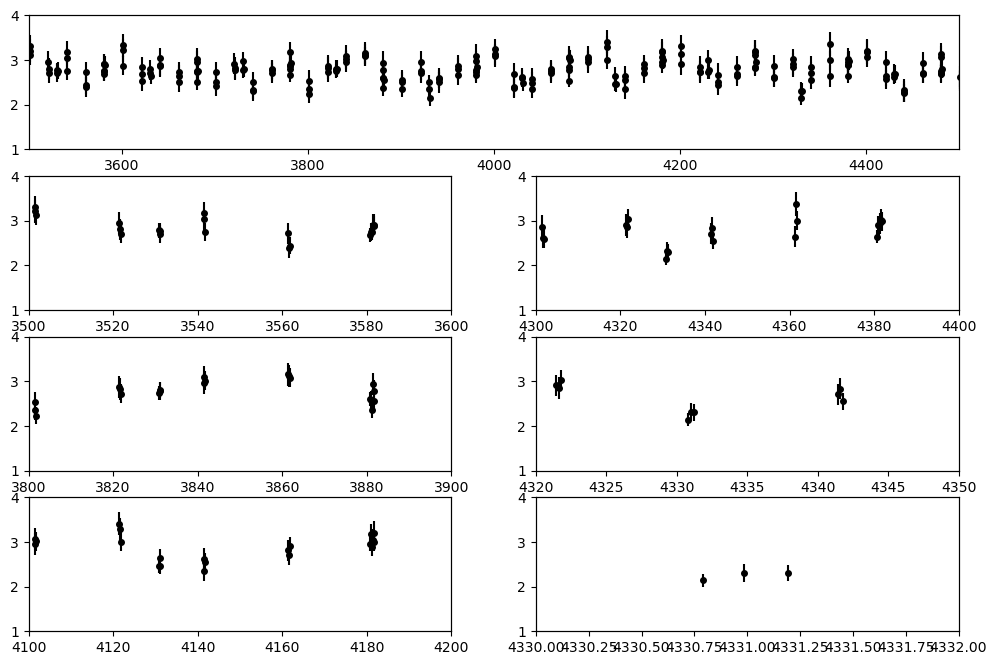

In [25]:
fig = plt.figure(figsize=(12,8),dpi=100)
gs = GridSpec(4, 2, figure=fig)

rng=[3500,4500]
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(my_time,my_out,label='Super res TS',color='dodgerblue')
ax1.fill_between(my_time,my_out-1.95*my_out_err,my_out+1.95*my_out_err,label='Super res TS',color='dodgerblue',alpha=0.2)

ax1.errorbar(meas_ts[n]['time'],meas_ts[n]['data'][:,idx_col],yerr=1.95*errbar[n]['data'][idx_col,:],color='k',ls='None',marker='o',markersize=4)
ax=ax1.twinx()
ax.plot(da['time'],da['data'],label='Da',color='darkorange',linewidth=1)
ax1.set(xlim=rng,ylim=[1,4])
ax.set(ylim=[0,0.1],xlim=rng,yticks=[])

for idx,rng in enumerate([[4300,4400],[4320,4350],[4330,4332]]):
    ax1 = fig.add_subplot(gs[idx+1, 1])
    ax1.fill_between(my_time,my_out-1.95*my_out_err,my_out+1.95*my_out_err,label='Super res TS',color='dodgerblue',alpha=0.2)
    ax1.plot(my_time,my_out,label='Super res TS',color='dodgerblue')
    ax1.errorbar(meas_ts[n]['time'],meas_ts[n]['data'][:,idx_col],yerr=1.95*errbar[n]['data'][idx_col,:],color='k',ls='None',marker='o',markersize=4)
    ax=ax1.twinx()
    ax.plot(da['time'],da['data'],label='Da',color='darkorange',linewidth=1)
    ax1.set(xlim=rng,ylim=[1,4])
    ax.set(ylim=[0,0.1],xlim=rng,yticks=[])

for idx,rng in enumerate([[3500,3600],[3800,3900],[4100,4200]]):
    ax1 = fig.add_subplot(gs[idx+1, 0])
    ax1.plot(my_time,my_out,label='Super res TS',color='dodgerblue')
    ax1.fill_between(my_time,my_out-1.95*my_out_err,my_out+1.95*my_out_err,label='Super res TS',color='dodgerblue',alpha=0.2)

    ax1.errorbar(meas_ts[n]['time'],meas_ts[n]['data'][:,idx_col],yerr=1.95*errbar[n]['data'][idx_col,:],color='k',ls='None',marker='o',markersize=4)
    ax=ax1.twinx()
    ax.plot(da['time'],da['data'],label='Da',color='darkorange',linewidth=1)
    ax1.set(xlim=rng,ylim=[1,4])
    ax.set(ylim=[0,0.1],xlim=rng,yticks=[])
plt.savefig('fig7.svg')
plt.savefig('fig7.png')

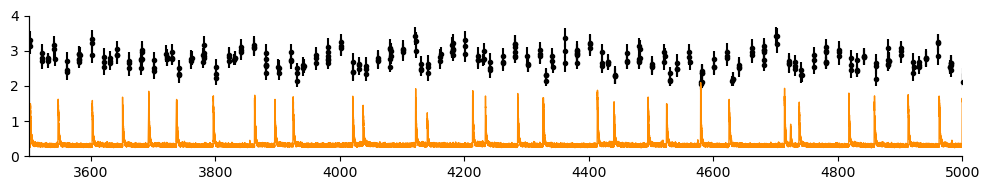

In [24]:
n='TS_ne'
idx_col=28

my_out=dict_hi_TS['L2'][n]['data'][:,idx_col]
my_out_err=dict_hi_TS['L2'][n]['error'][:,idx_col]
my_time = dict_hi_TS['time']

fig = plt.figure(figsize=(10,2),dpi=100)
gs = GridSpec(1, 2, figure=fig)


fmt='.'

rng=[3500,5000]
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(my_time,my_out,label='Super res TS',color='dodgerblue')
ax1.fill_between(my_time,my_out-1.95*my_out_err,my_out+1.95*my_out_err,label='Super res TS',color='dodgerblue',alpha=0.2)
ax1.errorbar(meas_ts[n]['time'],meas_ts[n]['data'][:,idx_col],yerr=1.95*errbar[n]['data'][idx_col,:],color='black',fmt=fmt)
# ax1.plot(meas_ts[n]['time'],meas_ts[n]['data'][:,idx_col],color='k',ls='None',marker='o',markersize=2.)

ax=ax1.twinx()
ax.plot(da['time'],da['data'],label='Da',color='darkorange',linewidth=1)
ax1.set(xlim=rng,ylim=[0,4])
ax.set(ylim=[-0.003,0.05],xlim=rng,yticks=[])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('fig3_top.svg')
# plt.savefig('fig3_top.png')

[Text(0, 0.5, 'b:0.80, r:0.86, g:0.89')]

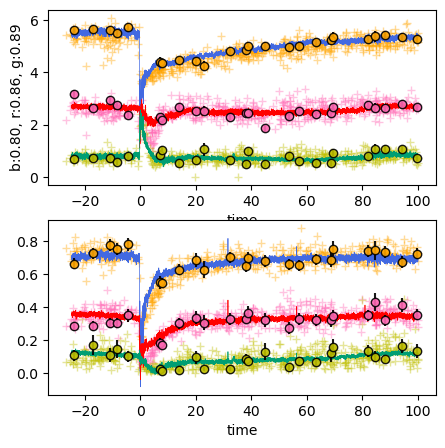

In [66]:
hf = h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_psirz.h5','r')
psiaxis_data=np.asarray(hf['EFIT_CAKE01']['psiaxis_data'])
psiaxis_time=np.asarray(hf['EFIT_CAKE01']['psiaxis_time'])
psibdy_data=np.asarray(hf['EFIT_CAKE01']['psibdy_data'])
psibdy_time=np.asarray(hf['EFIT_CAKE01']['psibdy_time'])
psirz_R=np.asarray(hf['EFIT_CAKE01']['psirz_R'])
psirz_Z=np.asarray(hf['EFIT_CAKE01']['psirz_Z'])
psirz_data=np.asarray(hf['EFIT_CAKE01']['psirz_data'])
psirz_time=np.asarray(hf['EFIT_CAKE01']['psirz_time'])
hf.close()

if all(psiaxis_time==psirz_time) and all(psibdy_time==psirz_time):
    for idx in range(psirz_data.shape[0]):
        psirz_data[idx,:,:]=(psirz_data[idx,:,:]-psiaxis_data[idx])/(psibdy_data[idx]-psiaxis_data[idx])

hf = h5py.File(f'{main_path}{shotn}_ts_rz.h5','r')
ts_r=np.asarray(hf['core.r']['zdata'],dtype=np.float32)
ts_z=np.asarray(hf['core.z']['zdata'],dtype=np.float32)
hf.close()

fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(5,5),dpi=100)
chns = [22,15,12]
psi=[]
for idx in chns:#zip(ts_r,ts_z):
    ts_r_idx=np.argmin(np.abs(psirz_R-ts_r[idx]))
    ts_z_idx=np.argmin(np.abs(psirz_Z-ts_z[idx]))
    psi.append(psirz_data[24,ts_r_idx,ts_z_idx])

ax=[]

clr_lst=['orange','hotpink',cbc['olive']]
# for elm_idx in tqdm(srts_windows_ne.keys()):

#     for i in axs:
#         for j in i:
#             j.cla()
elm_idx = list(spike_data_windows_ne.keys())[16]
# Print the data around each spike for verification
for window_ne, window_te in zip(spike_data_windows_ne.values(), spike_data_windows_te.values()):
    for col_id,cl in zip(chns,clr_lst):
        window_ne[f'ts_core_dens_{col_id+1}'].plot(ax=axs[0],marker='+',linestyle='',mfc = cl,mec=cl,alpha=0.4)
        window_te[f'ts_core_temp_{col_id+1}'].plot(ax=axs[1],marker='+',linestyle='',mfc = cl,mec=cl,alpha=0.4)

for col_id,cl,cl_real in zip(chns,clr_lst,[cbc['blue'],'red',cbc['gn']]):#['b','firebrick','k']):
    axs[0].plot(srts_windows_ne[elm_idx].index,srts_windows_ne[elm_idx][col_id],c=cl_real,linewidth=0.5)
    axs[1].plot(srts_windows_te[elm_idx].index,srts_windows_te[elm_idx][col_id],c=cl_real,linewidth=0.5)
    axs[0].errorbar(spike_data_windows_ne[elm_idx].index,spike_data_windows_ne[elm_idx][f'ts_core_dens_{col_id+1}'],yerr=spike_data_windows_ne_err[elm_idx][f'ts_err_core_dens_{col_id+1}'],marker='o',linestyle='',mfc = cl,mec='k',ecolor='k',alpha=0.9)
    axs[1].errorbar(spike_data_windows_te[elm_idx].index,spike_data_windows_te[elm_idx][f'ts_core_temp_{col_id+1}'],yerr=spike_data_windows_te_err[elm_idx][f'ts_err_core_temp_{col_id+1}'],marker='o',linestyle='',mfc = cl,mec='k',ecolor='k',alpha=0.9)

axs[0].set(ylabel=f'b:{psi[0]:.2f}, r:{psi[1]:.2f}, g:{psi[2]:.2f}')

In [67]:
elm_idx = list(spike_data_windows_ne.keys())[16]
window_ne, window_te = spike_data_windows_ne[elm_idx], spike_data_windows_te[elm_idx]
window_ne_srts, window_te_srts = srts_windows_ne[elm_idx], srts_windows_te[elm_idx]

elm_tm_idx=np.argmin(np.abs(window_ne.index.to_numpy()-0))
prof=dict()

if window_ne.index.to_numpy()[elm_tm_idx]>0:
    elm_tm={'bef':window_ne.real_elm_time.iloc[elm_tm_idx-1],'aft':window_ne.real_elm_time.iloc[elm_tm_idx]}
    prof['ne']={'bef':window_ne.iloc[elm_tm_idx-1,:],'aft':window_ne.iloc[elm_tm_idx,:]}
    prof['Te']={'bef':window_te.iloc[elm_tm_idx-1,:],'aft':window_te.iloc[elm_tm_idx,:]}
elif window_ne.index.to_numpy()[elm_tm_idx]<0:
    elm_tm={'bef':window_ne.real_elm_time.iloc[elm_tm_idx],'aft':window_ne.real_elm_time.iloc[elm_tm_idx+1]}
    prof['ne']={'bef':window_ne.iloc[elm_tm_idx,:],'aft':window_ne.iloc[elm_tm_idx+1,:]}
    prof['Te']={'bef':window_te.iloc[elm_tm_idx,:],'aft':window_te.iloc[elm_tm_idx+1,:]}
elm_tm

{'bef': 3790.819, 'aft': 3800.143}

In [68]:
elm_tm_srts_idx={'bef':np.argmin(np.abs(window_ne_srts.real_elm_time.to_numpy()-elm_tm['bef'])),
                 'aft':np.argmin(np.abs(window_ne_srts.real_elm_time.to_numpy()-elm_tm['aft']))}

prof_srts={'ne':window_ne_srts.iloc[elm_tm_srts_idx['bef']:elm_tm_srts_idx['aft'],:].to_numpy()}
prof_srts['Te']=window_te_srts.iloc[elm_tm_srts_idx['bef']:elm_tm_srts_idx['aft'],:].to_numpy()
prof_srts['time']=window_ne_srts.real_elm_time.iloc[elm_tm_srts_idx['bef']:elm_tm_srts_idx['aft']].to_numpy()

In [70]:
# Get psi for TS

hf = h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_psirz.h5','r')
psiaxis_data=np.asarray(hf['EFIT_CAKE01']['psiaxis_data'])
psiaxis_time=np.asarray(hf['EFIT_CAKE01']['psiaxis_time'])
psibdy_data=np.asarray(hf['EFIT_CAKE01']['psibdy_data'])
psibdy_time=np.asarray(hf['EFIT_CAKE01']['psibdy_time'])
psirz_R=np.asarray(hf['EFIT_CAKE01']['psirz_R'])
psirz_Z=np.asarray(hf['EFIT_CAKE01']['psirz_Z'])
psirz_data=np.asarray(hf['EFIT_CAKE01']['psirz_data'])
psirz_time=np.asarray(hf['EFIT_CAKE01']['psirz_time'])
hf.close()

if all(psiaxis_time==psirz_time) and all(psibdy_time==psirz_time):
    for idx in range(psirz_data.shape[0]):
        psirz_data[idx,:,:]=(psirz_data[idx,:,:]-psiaxis_data[idx])/(psibdy_data[idx]-psiaxis_data[idx])

hf = h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_ts_rz.h5','r')
ts_r=np.asarray(hf['core.r']['zdata'],dtype=np.float32)
ts_z=np.asarray(hf['core.z']['zdata'],dtype=np.float32)
hf.close()

ts_psi=dict()
for tm_idx,tm in enumerate(psirz_time):
    ts_psi[tm]=[]
    for idx in range(40):#zip(ts_r,ts_z):
        ts_r_idx=np.argmin(np.abs(psirz_R-ts_r[idx]))
        ts_z_idx=np.argmin(np.abs(psirz_Z-ts_z[idx]))
        ts_psi[tm].append(psirz_data[tm_idx,ts_r_idx,ts_z_idx])
    ts_psi[tm]=np.hstack(ts_psi[tm])

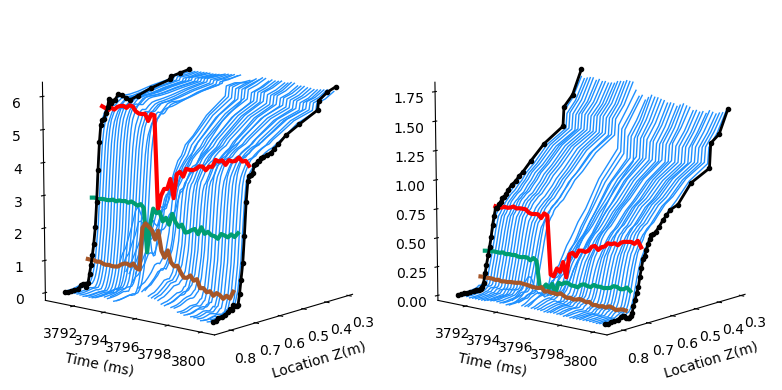

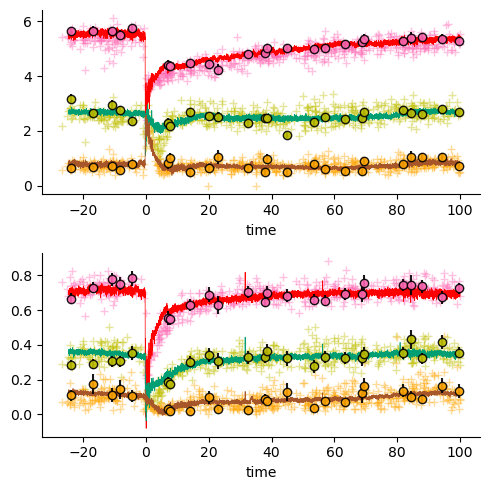

In [72]:
clr_lst=['hotpink',cbc['olive'],'orange']
# Example data
chns = [17,24,27]
loc_from=3
x = prof_srts['time'].copy()
# y = ts_psi[psi_time][ts_z_sort][loc_from:]
y = dict_hi_TS['TS_Z'][ts_z_sort][loc_from:]
X, Y = np.meshgrid(x, y)

Z=dict()
for ts_nm in ['ne','Te']:
    Z[ts_nm]=np.vstack([moving_average(prof_srts[ts_nm][x,ts_z_sort],2) for x in np.arange(0,prof_srts[ts_nm].shape[0])]).T


fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(8,4),dpi=100,subplot_kw={'projection': '3d'})



# Plot each line with color based on its value
for col_index in np.arange(0,len(x),20):
    if x[col_index]>3794.4 and x[col_index]<3795.5:
        lcl='dodgerblue'
        lw=1
    else:
        lcl='dodgerblue'
        lw=1
    for ax_idx,ts_nm in enumerate(['ne','Te']):
        line = axs[ax_idx].plot(y, np.full_like(y,x[col_index]), Z[ts_nm][:, col_index][loc_from:],color=lcl, linewidth=lw)

top_fig=[]
for chn,chnc in zip(chns,['red',cbc['gn'],cbc['bn']]):
    for ax_idx,ts_nm in enumerate(['ne','Te']):
        line = axs[ax_idx].plot(np.full_like(x[::20],y[chn]), x[::20], Z[ts_nm][chn, ::20],color=chnc, linewidth=3)
        top_fig.append(Z[ts_nm][chn, ::20])
        
for ax_idx,ts_nm in enumerate(['ne','Te']):
    line = axs[ax_idx].plot(y, np.full_like(y,x[0]), moving_average(prof[ts_nm]['bef'][ts_z_sort],2)[loc_from:],color='k', marker='o',markersize=3,linewidth=2)
    line = axs[ax_idx].plot(y, np.full_like(y,x[-1]), moving_average(prof[ts_nm]['aft'][ts_z_sort],2)[loc_from:],color='k',marker='o',markersize=3, linewidth=2)

    
for i,ts_nm in enumerate(['ne','Te']):
    axs[i].view_init(elev=10, azim=40, roll=0)
    axs[i].set(box_aspect=[1, 1, 1],xlabel="Location Z(m)",ylabel='Time (ms)')
    axs[i].grid(False)
    axs[i].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('fig3_3d.svg')

fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(5,5),dpi=100)

for window_ne, window_te in zip(spike_data_windows_ne.values(), spike_data_windows_te.values()):
    for col_id,cl in zip([ts_z_sort[x] for x in chns],clr_lst):
        window_ne[f'ts_core_dens_{col_id+1}'].plot(ax=axs[0],marker='+',linestyle='',mfc = cl,mec=cl,alpha=0.4)
        window_te[f'ts_core_temp_{col_id+1}'].plot(ax=axs[1],marker='+',linestyle='',mfc = cl,mec=cl,alpha=0.4)

bott_fig=[]
for col_id,cl,cl_real in zip([ts_z_sort[x] for x in chns],clr_lst,['red',cbc['gn'],cbc['bn']]):#['b','firebrick','k']):
    axs[0].plot(srts_windows_ne[elm_idx].index,srts_windows_ne[elm_idx][col_id],c=cl_real,linewidth=0.5)
    axs[1].plot(srts_windows_te[elm_idx].index,srts_windows_te[elm_idx][col_id],c=cl_real,linewidth=0.5)
    axs[0].errorbar(spike_data_windows_ne[elm_idx].index,spike_data_windows_ne[elm_idx][f'ts_core_dens_{col_id+1}'],yerr=spike_data_windows_ne_err[elm_idx][f'ts_err_core_dens_{col_id+1}'],marker='o',linestyle='',mfc = cl,mec='k',ecolor='k',alpha=0.9)
    axs[1].errorbar(spike_data_windows_te[elm_idx].index,spike_data_windows_te[elm_idx][f'ts_core_temp_{col_id+1}'],yerr=spike_data_windows_te_err[elm_idx][f'ts_err_core_temp_{col_id+1}'],marker='o',linestyle='',mfc = cl,mec='k',ecolor='k',alpha=0.9)
    bott_fig.append(srts_windows_ne[elm_idx][col_id])
for axid in axs:
    axid.spines['right'].set_visible(False)
    axid.spines['top'].set_visible(False)
    
    #plt.subplots_adjust(hspace=0.05)

    #plt.savefig(f'{shots[0]}_{shots[1]}_trace.png')
plt.tight_layout()
plt.savefig('fig3_2d.svg')

In [46]:
clr_lst

['dodgerblue', 'hotpink', '#bfbf00']

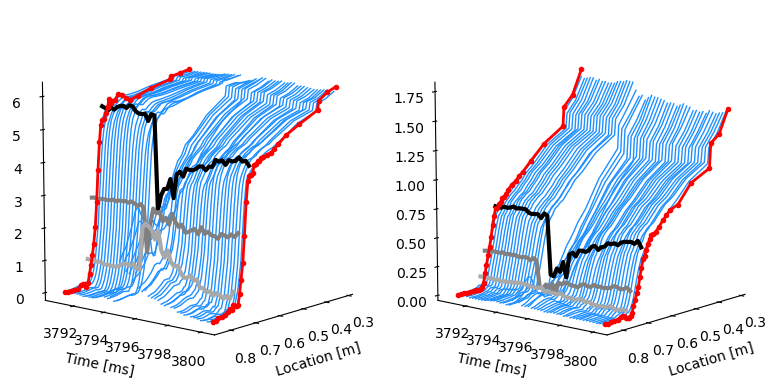

In [125]:
fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(8,4),dpi=100,subplot_kw={'projection': '3d'})



# Plot each line with color based on its value
for col_index in np.arange(0,len(x),20):
    if x[col_index]>3794.4 and x[col_index]<3795.5:
        lcl='dodgerblue'
        lw=1
    else:
        lcl='dodgerblue'
        lw=1
    for ax_idx,ts_nm in enumerate(['ne','Te']):
        line = axs[ax_idx].plot(y, np.full_like(y,x[col_index]), Z[ts_nm][:, col_index][loc_from:],color=lcl, linewidth=lw)

top_fig=[]
for chn,chnc in zip(chns,['k','gray','darkgray']):
    for ax_idx,ts_nm in enumerate(['ne','Te']):
        line = axs[ax_idx].plot(np.full_like(x[::20],y[chn]), x[::20], Z[ts_nm][chn, ::20],color=chnc, linewidth=3)
        top_fig.append(Z[ts_nm][chn, ::20])
        
for ax_idx,ts_nm in enumerate(['ne','Te']):
    line = axs[ax_idx].plot(y, np.full_like(y,x[0]), moving_average(prof[ts_nm]['bef'][ts_z_sort],2)[loc_from:],color='r', marker='o',markersize=3,linewidth=2)
    line = axs[ax_idx].plot(y, np.full_like(y,x[-1]), moving_average(prof[ts_nm]['aft'][ts_z_sort],2)[loc_from:],color='r',marker='o',markersize=3, linewidth=2)

    
for i,ts_nm in enumerate(['ne','Te']):
    axs[i].view_init(elev=10, azim=40, roll=0)
    axs[i].set(box_aspect=[1, 1, 1],xlabel="Location [m]",ylabel='Time [ms]')
    axs[i].grid(False)
    axs[i].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{shotn}.svg')

In [134]:
dict_hi_TS['TS_Z'][12]

0.718

In [69]:
# fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(10,5),subplot_kw={'projection': '3d'})



# for ax_idx,ts_nm in enumerate(['ne','Te']):
#     surface = axs[ax_idx].plot_surface(X, Y, Z[ts_nm][loc_from:,:], cmap=cm.jet)
#     axs[ax_idx].view_init(elev=30, azim=45, roll=0)
#     axs[ax_idx].set(box_aspect=[1, 1, 1],xlim=[x[-1],x[0]],ylabel='Location (m)',xlabel='Time (ms)')
#     axs[ax_idx].grid(False)
    
#     axs[ax_idx].spines['right'].set_visible(False)
#     axs[ax_idx].spines['top'].set_visible(False)

# # axs[0].scatter(X, Y, Z.flatten(), c=Z.flatten(), cmap=cm.jet,linewidths=1)


# plt.tight_layout()


In [77]:
hf = h5py.File(f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/{shotn}_psirz.h5','r')
psiaxis_data=np.asarray(hf['EFIT_CAKE01']['psiaxis_data'])
psiaxis_time=np.asarray(hf['EFIT_CAKE01']['psiaxis_time'])
psibdy_data=np.asarray(hf['EFIT_CAKE01']['psibdy_data'])
psibdy_time=np.asarray(hf['EFIT_CAKE01']['psibdy_time'])
psirz_R=np.asarray(hf['EFIT_CAKE01']['psirz_R'])
psirz_Z=np.asarray(hf['EFIT_CAKE01']['psirz_Z'])
psirz_data=np.asarray(hf['EFIT_CAKE01']['psirz_data'])
psirz_time=np.asarray(hf['EFIT_CAKE01']['psirz_time'])
hf.close()

if all(psiaxis_time==psirz_time) and all(psibdy_time==psirz_time):
    for idx in range(psirz_data.shape[0]):
        psirz_data[idx,:,:]=(psirz_data[idx,:,:]-psiaxis_data[idx])/(psibdy_data[idx]-psiaxis_data[idx])

hf = h5py.File(f'{main_path}{shotn}_ts_rz.h5','r')
ts_r=np.asarray(hf['core.r']['zdata'],dtype=np.float32)
ts_z=np.asarray(hf['core.z']['zdata'],dtype=np.float32)
hf.close()

for idx in range(40):#zip(ts_r,ts_z):
    ts_r_idx=np.argmin(np.abs(psirz_R-ts_r[idx]))
    ts_z_idx=np.argmin(np.abs(psirz_Z-ts_z[idx]))
    psi= psirz_data[24,ts_r_idx,ts_z_idx]
    print(psi)
    

1.0147258
1.0147258
0.9801457
0.9801457
0.9470889
0.9470889
0.91612345
0.91612345
0.91612345
0.8861334
0.8861334
0.8861334
0.8861334
0.8861334
0.85695887
0.85695887
0.85695887
0.82856506
0.82856506
0.82856506
0.82856506
0.8009333
0.8009333
0.8009333
0.8009333
0.774059
0.774059
0.7479489
0.7479489
0.722618
0.722618
0.67438364
0.62957233
0.56931925
0.56931925
0.53415644
0.51816297
0.48947582
0.44583055
0.41580737


0.98
0.95
0.89


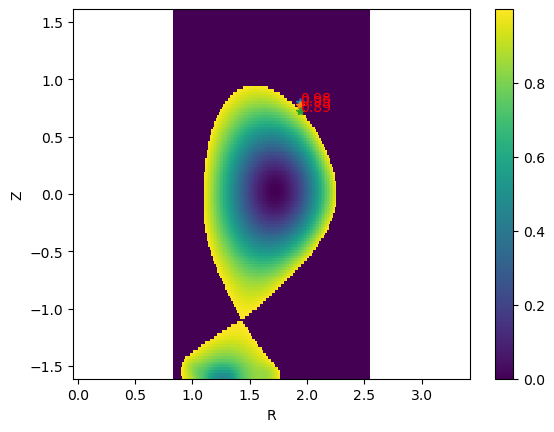

In [315]:


plt.pcolormesh(psirz_R,psirz_Z,np.where(psirz_data[24,:,:]<1,psirz_data[24,:,:],0))

for idx in [3,4,9]:#zip(ts_r,ts_z):
    ts_r_idx=np.argmin(np.abs(psirz_R-ts_r[idx]))
    ts_z_idx=np.argmin(np.abs(psirz_Z-ts_z[idx]))
    psi= psirz_data[24,ts_r_idx,ts_z_idx]
    print(f'{psi:.2f}')

    plt.plot(psirz_R[ts_r_idx],psirz_Z[ts_z_idx],marker='*')
    plt.text(psirz_R[ts_r_idx],psirz_Z[ts_z_idx],f'{psi:.2f}',c='r')
plt.xlabel('R')
plt.ylabel('Z')
plt.axis('equal')
plt.colorbar()

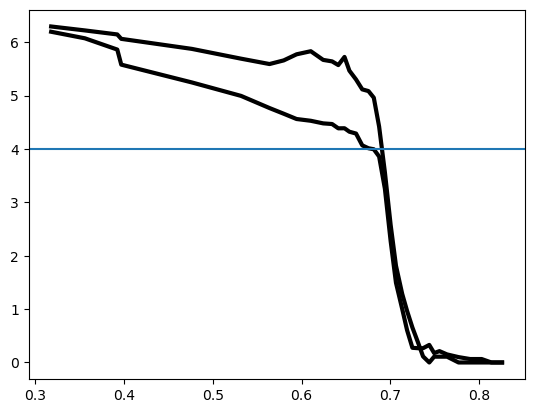

In [145]:
for ax_idx,ts_nm in enumerate(['ne']):
    line = plt.plot(y, moving_average(prof[ts_nm]['bef'][ts_z_sort],2)[loc_from:],color='k', linewidth=3)
    line = plt.plot(y, moving_average(prof[ts_nm]['aft'][ts_z_sort],2)[loc_from:],color='k', linewidth=3)

plt.axhline(4)

In [252]:
hf = h5py.File(f'{main_path}{shotn}_ts_rz.h5','r')
ts_pos='core'
meas_ts=dict()
for ts_idx,m_idx,coeff in zip(['dens','temp'],['TS_ne','TS_Te'],[1.e-19,1.e-3]):
    sig_time = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['xdata'],dtype=np.float32)
    sig_data = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['zdata'],dtype=np.float32).T
    sig_pos = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['ydata'],dtype=np.float32)
    meas_ts[m_idx]={'data':sig_data*coeff, 'time':sig_time}
hf.close()

KeyError: "Unable to open object (object 'core.dens' doesn't exist)"

In [23]:
ls /scratch/gpfs/EKOLEMEN/aj17/*_prefinal.pkl

/scratch/gpfs/EKOLEMEN/aj17/153764_prefinal.pkl
/scratch/gpfs/EKOLEMEN/aj17/157545_prefinal.pkl
/scratch/gpfs/EKOLEMEN/aj17/174823_prefinal.pkl
/scratch/gpfs/EKOLEMEN/aj17/190346_prefinal.pkl
/scratch/gpfs/EKOLEMEN/aj17/190348_prefinal.pkl


In [6]:
data=pickle.load(open('/scratch/gpfs/EKOLEMEN/aj17/178942_prefinal.pkl','rb')) 

In [8]:
data['time'].shape

(2851576,)

In [31]:
spec_params={
    'nperseg': 2048, # default 1024
    'noverlap': 1984, # default: nperseg / 4
    'fs': 500000, # fast ECE signal sample rate is 500KHz
    'window': 'hamm',
    'scaling': 'density', # {'density', 'spectrum'}
    'detrend': 'linear', # {'linear', 'constant', False}
    'eps': 1e-11} 

srts={'TS_Te':{},'TS_ne':{}}

for idx in ['TS_Te','TS_ne']:
    srts[idx]['Sxx'],srts[idx]['Sxx_enhanced'],srts[idx]['f'],srts[idx]['t'] = specgr(data['L2'][idx]['data'][:,8],spec_params)

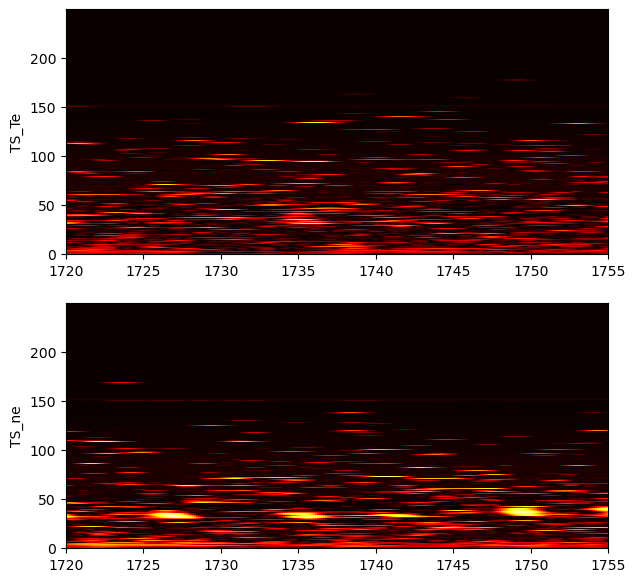

In [32]:
fig,axs=plt.subplots(ncols=1,nrows=2,figsize=(7,7))
for i,idx in enumerate(['TS_Te','TS_ne']):
    axs[i].pcolormesh(srts[idx]['t']+data['time'][0],srts[idx]['f'],srts[idx]['Sxx_enhanced'],cmap='hot')
    axs[i].set(xlim=[1720,1755],ylabel=idx)

In [4]:
shotn = 157545

main_path=f'/scratch/gpfs/EKOLEMEN/big_d3d_data/{shotn-np.mod(shotn,10000)}/'
# dict_hi_TS = pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/{shotn}_prefinal.pkl','rb'))
dict_hi_TS = pickle.load(open(f'/scratch/gpfs/EKOLEMEN/aj17/shared/{shotn}_TS_SuperRes_ensemble_onlyonshot.pkl','rb'))


errbar=dict()
hf = h5py.File(f'{main_path}{shotn}_ts_error.h5','r')
errbar['TS_ne']={'data':np.asarray(hf['core.dens']['zdata'])*1.e-19,
                'time':np.asarray(hf['core.dens']['xdata'])}
errbar['TS_Te']={'data':np.asarray(hf['core.temp']['zdata'])*1.e-3,
                'time':np.asarray(hf['core.temp']['xdata'])}
hf.close()

hf = h5py.File(f'{main_path}{shotn}_ts.h5','r')
ts_pos='core'
meas_ts=dict()
for ts_idx,m_idx,coeff in zip(['dens','temp'],['TS_ne','TS_Te'],[1.e-19,1.e-3]):
    sig_time = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['xdata'],dtype=np.float32)
    sig_data = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['zdata'],dtype=np.float32).T
    sig_pos = np.asarray(hf['%s.%s' % (ts_pos,ts_idx)]['ydata'],dtype=np.float32)
    meas_ts[m_idx]={'data':sig_data*coeff, 'time':sig_time}
hf.close()


with h5py.File(f'{main_path}{shotn}_basic.h5', 'r') as actu_file:
    da={'time':np.asarray(actu_file['fs00']['xdata']),
        'data':np.asarray(actu_file['fs00']['zdata'])*1e-17}
    
ts_z_sort=sorted(range(len(dict_hi_TS['TS_Z'])), key=lambda k: dict_hi_TS['TS_Z'][k])
ts_z_sort = filter(lambda k: k < 40, ts_z_sort)
ts_z_sort = list(ts_z_sort)
new_idx_col=np.argmin(abs(dict_hi_TS['TS_Z'][ts_z_sort]-dict_hi_TS['TS_Z'][idx_col]))



NameError: name 'idx_col' is not defined

In [ ]:
time_rng=[5550,5650]

srts_tm=[np.argmin(np.abs(dict_hi_TS['TS_Te']['pred']['time']-time_rng[0])),np.argmin(np.abs(dict_hi_TS['TS_Te']['pred']['time']-time_rng[1]))]
ts_tm=[np.argmin(np.abs(dict_hi_TS['TS_Te']['truth']['time']-time_rng[0])),np.argmin(np.abs(dict_hi_TS['TS_Te']['truth']['time']-time_rng[1]))]


loc_from=3
x = dict_hi_TS['TS_Te']['pred']['time'][srts_tm[0]:srts_tm[1]:50]
y = dict_hi_TS['TS_Z'][ts_z_sort][loc_from:]
X, Y = np.meshgrid(x, y)

chns = [17,24,27]

Z=dict()
for ts_nm in ['TS_ne','TS_Te']:
    z= dict_hi_TS[ts_nm]['pred']['data'][srts_tm[0]:srts_tm[1]:50,:]
    z_err = dict_hi_TS[ts_nm]['pred']['error'][srts_tm[0]:srts_tm[1]:10,loc_from:].T
    Z[ts_nm]=np.vstack([moving_average(z[x,ts_z_sort],2) for x in np.arange(0,z.shape[0])]).T

fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(8,4),dpi=100,subplot_kw={'projection': '3d'})



# Plot each line with color based on its value
for col_index in np.arange(0,len(x),20):
    lcl='dodgerblue'
    lw=1
    for ax_idx,ts_nm in enumerate(['TS_ne','TS_Te']):
#         line = axs[ax_idx].errorbar(y, np.full_like(y,x[col_index]), Z[ts_nm][:, col_index][loc_from:],zerr=2*z_err[:,col_index],color=lcl, linewidth=lw)
        line = axs[ax_idx].plot(y, np.full_like(y,x[col_index]), Z[ts_nm][:, col_index][loc_from:],color=lcl, linewidth=lw)

top_fig=[]
for chn,chnc in zip(chns,['red',cbc['gn'],cbc['bn']]):
    for ax_idx,ts_nm in enumerate(['TS_ne','TS_Te']):
#         line = axs[ax_idx].plot(np.full_like(x[::20],y[chn]), x[::20], Z[ts_nm][chn, ::20],color=chnc, linewidth=3)
        top_fig.append(Z[ts_nm][chn, ::20])

for ax_idx,ts_nm in enumerate(['TS_ne','TS_Te']):
    for tm in np.arange(ts_tm[0],ts_tm[1]+1):
        line = axs[ax_idx].plot(y, np.full_like(y,dict_hi_TS[ts_nm]['truth']['time'][tm]), moving_average(dict_hi_TS[ts_nm]['truth']['data'][tm,ts_z_sort],2)[loc_from:],color='k', marker='o',markersize=3,linewidth=2)

        
for i,ts_nm in enumerate(['TS_ne','TS_Te']):
    axs[i].view_init(elev=10, azim=50, roll=0)
    axs[i].set(box_aspect=[1, 1, 1],xlabel="Location Z(m)",ylabel='Time (ms)')
    axs[i].grid(False)
    axs[i].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{shotn}_extra.svg')

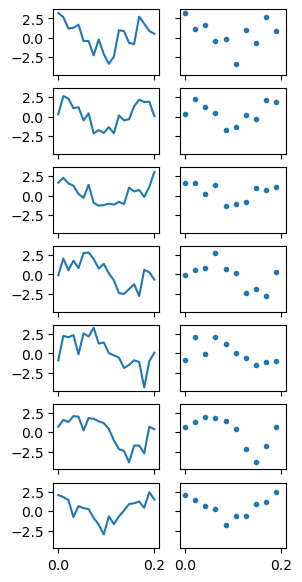

In [35]:
import numpy as np
import matplotlib.pyplot as plt

fig,axs=plt.subplots(ncols=2,nrows=7,figsize=(3,7),sharex=True,sharey=True)
# Parameters for the random signal
num_samples = 20  # Number of points in the signal
sampling_rate = 100  # Sampling rate in Hz
signal_duration = num_samples / sampling_rate  # Signal duration in seconds

# Generate a random signal
time = np.linspace(0, signal_duration, num_samples)

for idx in range(7):
    signal = np.random.randn(num_samples)  # Generate random samples from a normal distribution
    a = np.random.rand(2)
    # Add a sinusoidal DC component to the signal
    dc_frequency = 5  # Frequency of the sinusoidal DC component in Hz
    dc_amplitude = 2  # Amplitude of the sinusoidal DC component
    if a[1]>a[0]:
        sinusoidal_dc = dc_amplitude * np.sin(2 * np.pi * dc_frequency * time)
    else:
        sinusoidal_dc = dc_amplitude * np.cos(2 * np.pi * dc_frequency * time)

    signal += sinusoidal_dc

    # Plot the random signal with sinusoidal DC component
    axs[idx,0].plot(time, signal)
    axs[idx,1].plot(time[::2], signal[::2],'.')
    
plt.savefig(f'extra_fig.svg')

In [54]:
err=pickle.load(open('error_measured_pred_150k.pkl','rb'))
err['error_pred'].keys()

dict_keys([157543, 157542, 157537, 157532, 157538, 157544, 157536, 157539, 157546, 157533, 157540, 157535, 157545, 157534])

In [22]:
np.random.rand(2)

array([0.9850063 , 0.98779423])

In [137]:
uq[:,1]

array([1.33025255, 0.71402744, 0.54131012, 0.35754234, 0.26405393,
       0.21086419, 0.1465598 , 0.12344251, 0.08425312, 0.05739636])

In [42]:
xx=512
yy=256
zz=128
print((236*(xx+1))+(xx*(yy+1))+(yy*(zz+1))+(zz*80))

295916
